# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **ECCO**

In [2]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
client

<Client: 'tls://10.8.1.27:8786' processes=30 threads=60, memory=120.00 GiB>

In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
import json

In [5]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
coords = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
#ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_theta.zarr'))
#ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt.zarr'))
ds_sig_salt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt_new.zarr'))
#ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_rhodts.zarr')) #typo in filename - should be 'drhodts'
ds_drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/drhodts_new.zarr')) 

In [8]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])
ds

<xarray.Dataset>
Dimensions:                  (time: 288, k: 50, j: 50, i: 95, i_g: 96, j_g: 51, k_l: 50)
Coordinates:
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                      (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: j, i, i_g, j_g
Data variables: (12/20)
    conv_horiz_adv_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    ...                       ...
    UVEL                     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    UVELSTAR                 (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    VVELSTAR                 (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    WVELSTAR                 (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [8]:
ds_tns.SALT

<xarray.DataArray 'SALT' (time: 288, k: 50, j: 50, i: 95)>
dask.array<open_dataset-279c91a1c659f48bf862cca327a6085aSALT, shape=(288, 50, 50, 95), dtype=float32, chunksize=(1, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      Salinity
    standard_name:  SALT
    units:          psu

In [9]:
mask = ds.G_forc.where(ds.G_forc!=0)

In [10]:
mask

<xarray.DataArray 'G_forc' (time: 288, k: 50, j: 50, i: 95)>
dask.array<where, shape=(288, 50, 50, 95), dtype=float64, chunksize=(48, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

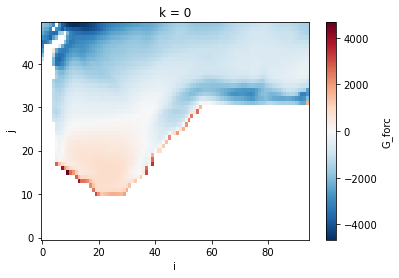

In [11]:
mask.mean(dim='time')[0].plot()

In [11]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [12]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [13]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [14]:
pref=2000

### Renaming G terms to be old terms for nb convenience

In [15]:
ds['conv_adv_flux_SLT'] = ds.G_adv + ds.G_adv_conv

ds['conv_diff_flux_SLT'] = ds.G_diff

ds['surface_flux_SLT'] = ds.G_forc

ds['total_tendency_SLT_truth'] = ds.G_tot

In [16]:
ds

<xarray.Dataset>
Dimensions:                   (time: 288, k: 50, j: 50, i: 95, i_g: 96, j_g: 51, k_l: 50)
Coordinates:
  * k                         (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * k_l                       (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: j, i, i_g, j_g
Data variables: (12/24)
    conv_horiz_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH      (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH           (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    ...                        ...
    WVEL                      (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    WVELSTAR                  (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    conv_adv_flux_SLT         (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    conv_diff_flux_SLT        (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    surface_flux_SLT          (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    total_tendency_SLT_truth  (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>

### Checking if `rhs` and `lhs` seem to match

In [17]:
ds_sig_salt.data_vars

Data variables:
    G_adv       (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot       (time, k, j, i) float64 dask.array<chunksize=(72, 13, 13, 24), meta=np.ndarray>

In [18]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'G_tot']

In [19]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

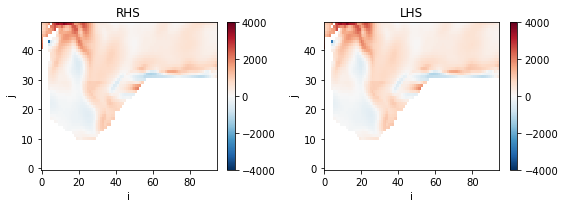

In [20]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

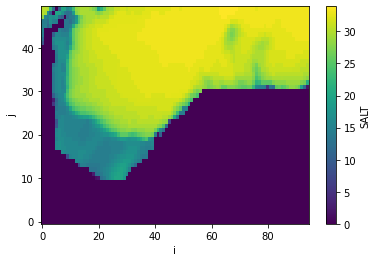

In [22]:
ds_tns.SALT.mean(dim=['time', 'k']).plot()

In [20]:
sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/sigma2_vars.zarr'))
sigma2 = sigma2_vars.sigma2
sigma2_snp = sigma2_vars.sigma2_snp

In [21]:
vol = (coords.drF * coords.rA * coords.hFacC)

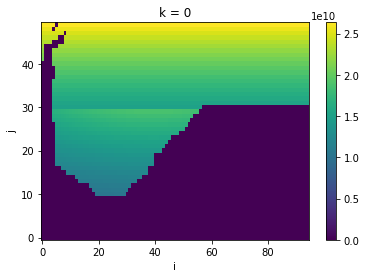

In [22]:
vol[0].plot()

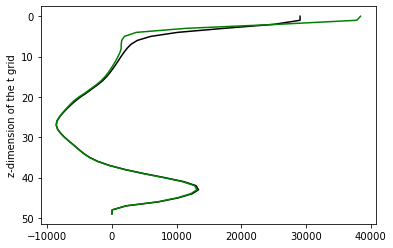

In [23]:
delta_sigma = sigma2_snp.isel(time_snp=-1) - sigma2_snp.isel(time_snp=0)
total_time = (sigma2_snp.time_snp[-1] - sigma2_snp.time_snp[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['j', 'i'])/ total_time).plot(y='k', yincrease=False, color='k')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='green')

In [24]:
totend_truth = (delta_sigma * vol) / total_time

In [26]:
sigma2.time.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [27]:
sigma2_snp.time_snp.coords

Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01

In [28]:
sigma2.diff(dim='time').coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14

In [29]:
coords.dt[1:]

<xarray.DataArray 'dt' (time: 287)>
dask.array<getitem, shape=(287,), dtype=float32, chunksize=(287,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14

In [25]:
dsig_dt = (sigma2.diff(dim='time')*vol)/coords.dt[1:]

In [31]:
vol

<xarray.DataArray (k: 50, j: 50, i: 95)>
dask.array<mul, shape=(50, 50, 95), dtype=float32, chunksize=(50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [27]:
totend_truth.coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49

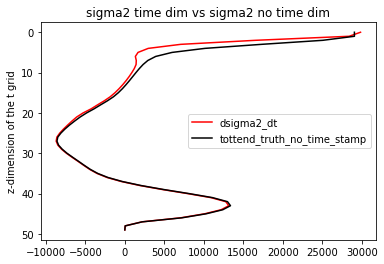

In [33]:
dsig_dt.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='red', label='dsigma2_dt')
totend_truth.sum(dim=['j', 'i']).plot(y='k', yincrease=False, color='k', label='tottend_truth_no_time_stamp')

plt.title('sigma2 time dim vs sigma2 no time dim')
plt.legend();

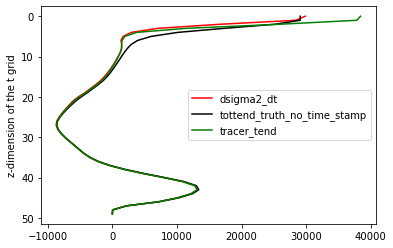

In [34]:
dsig_dt.sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='red', label='dsigma2_dt')
totend_truth.sum(dim=['j', 'i']).plot(y='k', yincrease=False, color='k', label='tottend_truth_no_time_stamp')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['j', 'i']).mean(dim='time').plot(y='k', yincrease=False, color='green', label='tracer_tend')
plt.legend();

In [26]:
totend_truth = (sigma2.diff(dim='time') * vol) / coords.dt[1:]

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

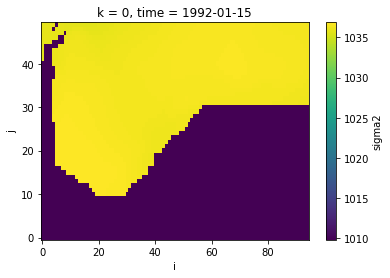

In [36]:
sigma2[0,0].plot()

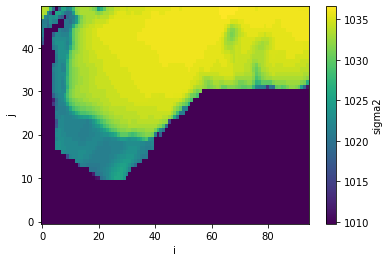

In [33]:
sigma2.mean(dim=['time', 'k']).plot()

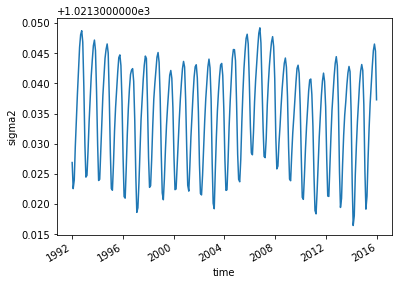

In [38]:
sigma2.mean(dim=['i', 'j', 'k']).plot()

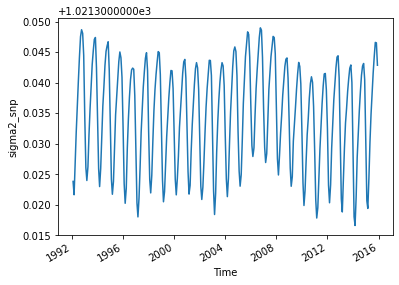

In [39]:
sigma2_snp.mean(dim=['i', 'j', 'k']).plot()

In [29]:
(1037.27-1036.9)/1000

0.00036999999999989087

In [27]:
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [28]:
sigma_bins.size

1000

In [29]:
vol = vol.chunk({'i':-1, 'j':-1, 'k':-1})
sigma2 = sigma2.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
sigma2_snp = sigma2_snp.chunk({'i':-1, 'j':-1, 'k':-1, 'time_snp':1})
ds = ds.chunk({'i':-1, 'j':-1, 'k':-1, 'i_g':-1, 'j_g':-1, 'k_l':-1, 'time':1})
ds_sig_salt = ds_sig_salt.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})
ds_sig_theta = ds_sig_theta.chunk({'i':-1, 'j':-1, 'k':-1, 'time':1})

In [30]:
sigma_dist = histogram(sigma2_snp.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['i', 'j', 'k']).load()

(1036.8, 1037.4)

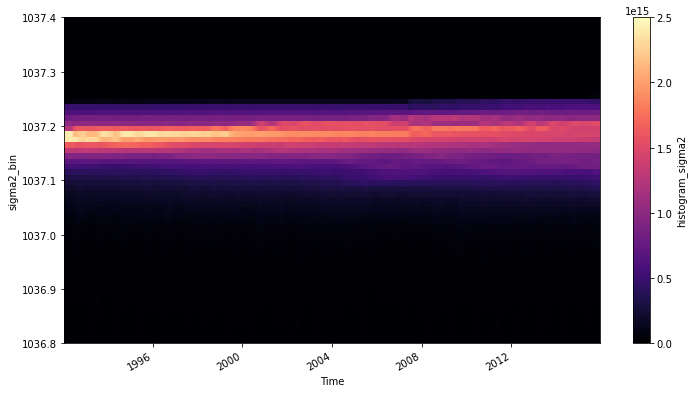

In [31]:
sigma_dist.plot(x='time_snp', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.8, 1037.4)

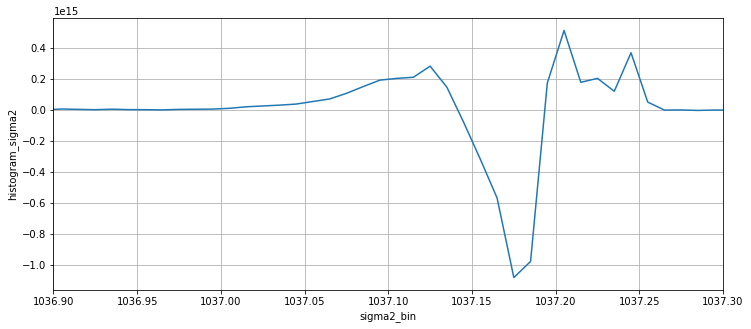

In [25]:
plt.figure(figsize=(12,5))
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1036.9, 1037.3)
plt.grid();

In [47]:
plt.figure(figsize=(12,5))
R3 = wmt_budget_terms.omega_total - wmt_budget_terms.psi_adv - wmt_budget_terms.omega_trans_rate
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='lhs') 
((wmt_budget_terms.omega_trans_rate + wmt_budget_terms.psi_adv + wmt_budget_terms.R1 + R3)/1e6).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
plt.legend()
plt.ylabel('Sv')
#plt.xlim(1036.5, 1037.3)
plt.grid();

NameError: name 'wmt_budget_terms' is not defined

<Figure size 864x360 with 0 Axes>

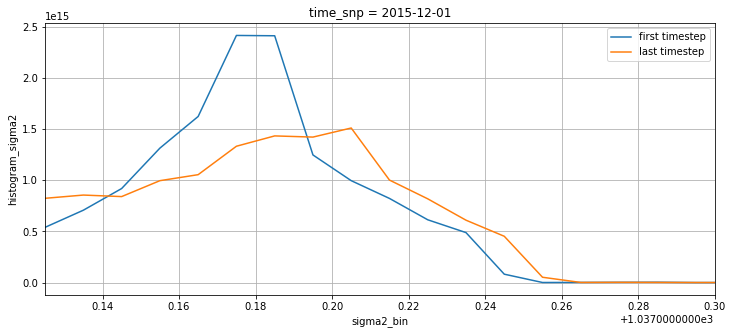

In [27]:
plt.figure(figsize=(12,5))
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.125, 1037.3)
plt.grid();

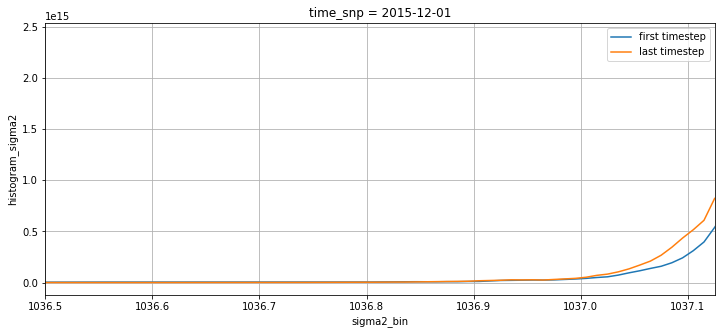

In [28]:
plt.figure(figsize=(12,5))
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.125)
plt.grid();

In [29]:
bottom_vol = (sigma_dist.mean('time_snp').isel(sigma2_bin=-1) - sigma_dist.mean('time_snp').sel(sigma2_bin=1037.125, method='nearest'))/1e6

In [30]:
deep_vol = (sigma_dist.mean('time_snp').sel(sigma2_bin=1037.125, method='nearest') - 
            sigma_dist.mean('time_snp').isel(sigma2_bin=0))/1e6

In [32]:
bottom_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(-6.39165692e+08)

In [31]:
deep_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(6.39273133e+08)

In [33]:
bottom_vol + deep_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(107441.29126394)

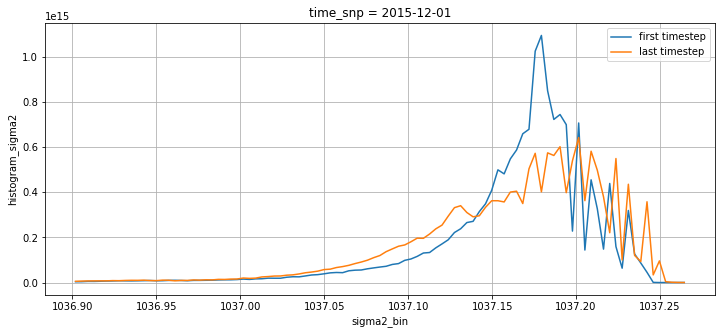

In [47]:
plt.figure(figsize=(12,5))
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1036.5, 1037.3)
plt.grid();

#### Need to redescribe after changing sigma bin range and size
- 1037.1-1037.13: volume is added (3rd plot), positive lobe meaning volume is increasing (1st plot), negative slope meaning the rate of cumulative volume distribution is decreasing so therefore, more water buildup of waters in this range bc of less distribution of the waters (that’s why you see more volume in “last timestep” and positive lobe in 1st plot). 

- 1037.15-1037.2: volume is lost (3rd plot), negative lobe meaning volume is decreasing (1st plot), positive slope meaning increased volume distribution meaning waters in this range are being distributed at a higher rate (that’s why you see less volume in “last timestep” and negative lobe in 1st plot).

(1037.27, 1036.9)

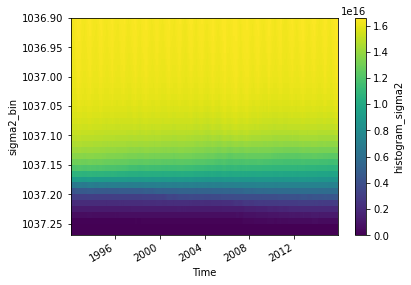

In [32]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.27, 1036.9)

(1037.125, 1037.3)

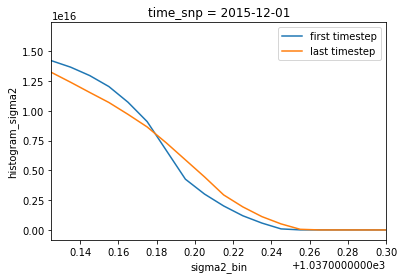

In [33]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.125, 1037.3)

(1036.5, 1037.125)

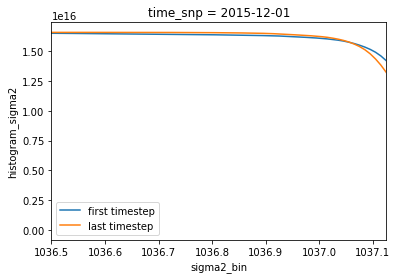

In [34]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.5, 1037.125)

In [35]:
bottom_cum_vol = (V.mean('time_snp').isel(sigma2_bin=-1) - V.mean('time_snp').sel(sigma2_bin=1037.125, method='nearest'))/1e6

In [40]:
deep_cum_vol = (V.mean('time_snp').sel(sigma2_bin=1037.125, method='nearest') - 
            V.mean('time_snp').isel(sigma2_bin=0))/1e6

In [41]:
bottom_cum_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(3.02909977e+09)

In [42]:
deep_cum_vol

<xarray.DataArray 'histogram_sigma2' ()>
array(1.35504071e+10)

(1037.27, 1036.9)

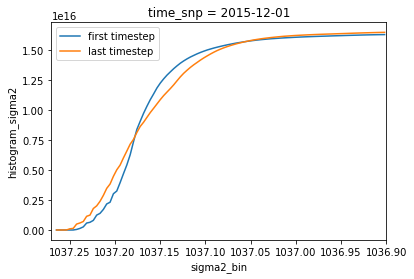

In [37]:
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.27, 1036.9)

In [38]:
V

<xarray.DataArray 'histogram_sigma2' (time_snp: 287, sigma2_bin: 99)>
array([[3.5638958e+11, 6.3549132e+11, 7.9710945e+11, ..., 1.6279789e+16,
        1.6283701e+16, 1.6287290e+16],
       [1.8574955e+11, 7.6602927e+11, 1.0215721e+12, ..., 1.6249878e+16,
        1.6254072e+16, 1.6257912e+16],
       [2.0832961e+11, 5.3596766e+11, 1.0897014e+12, ..., 1.6228329e+16,
        1.6232279e+16, 1.6236137e+16],
       ...,
       [5.6868379e+11, 1.1905827e+12, 1.9198930e+12, ..., 1.6493515e+16,
        1.6497113e+16, 1.6502260e+16],
       [4.7023384e+11, 1.0726310e+12, 1.9549803e+12, ..., 1.6501259e+16,
        1.6506860e+16, 1.6512190e+16],
       [2.3305037e+11, 7.4377173e+11, 2.0647977e+12, ..., 1.6462959e+16,
        1.6469475e+16, 1.6475138e+16]], dtype=float32)
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [35]:
delta_V = V.diff(dim='time_snp')
delta_V.coords['time'] = 'time_snp', ds_tns.time[1:-1].values

In [36]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time_snp: 286, sigma2_bin: 999)>
array([[ 0.0000000e+00, -3.4496011e+11,  0.0000000e+00, ...,
         2.1474836e+09,  2.1474836e+09,  2.1474836e+09],
       [ 0.0000000e+00, -4.9544323e+10,  0.0000000e+00, ...,
         3.2212255e+09,  3.2212255e+09,  3.2212255e+09],
       [ 0.0000000e+00, -6.0026757e+10,  0.0000000e+00, ...,
        -2.2548578e+10, -2.2548578e+10, -2.2548578e+10],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.2212255e+09,  3.2212255e+09,  3.2212255e+09],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.1474836e+09, -2.1474836e+09, -2.1474836e+09]], dtype=float32)
Coordinates:
  * time_snp    (time_snp) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
    time        (time_snp) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

## $\frac{\partial \mathcal{V}}{\partial t}$

In [37]:
dVdt = delta_V.swap_dims({'time_snp': 'time'}) / ds_tns.dt[1:-1]

In [38]:
dVdt

<xarray.DataArray (time: 286, sigma2_bin: 999)>
dask.array<true_divide, shape=(286, 999), dtype=float32, chunksize=(286, 999), chunktype=numpy.ndarray>
Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [50]:
bottom_dvdt = (dVdt.mean('time').isel(sigma2_bin=-1) - dVdt.mean('time').sel(sigma2_bin=1037.125, method='nearest'))/1e6

In [53]:
deep_dvdt = (dVdt.mean('time').sel(sigma2_bin=1037.125, method='nearest') - 
            dVdt.mean('time').isel(sigma2_bin=0))/1e6

In [55]:
bottom_dvdt.values

array(1.3362118, dtype=float32)

In [57]:
deep_dvdt.values

array(-1.3362039, dtype=float32)

(1036.9, 1037.27)

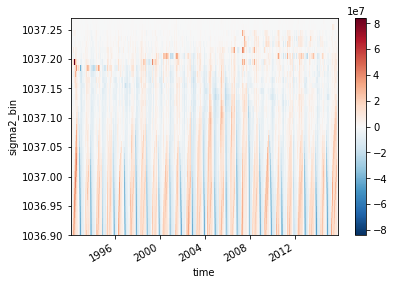

In [40]:
dVdt.plot(x='time')
plt.ylim(1036.9, 1037.27)

## $\Omega_{total}$

In [40]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['i', 'j', 'k']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['i', 'j', 'k']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -6845.07302107, -2648.78741706,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -9264.73550977,   -55.58460345,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [60]:
sigma2[1:].coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14

In [61]:
totend_truth.coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14

In [34]:
client.restart()

<Client: 'tls://10.8.4.5:8786' processes=0 threads=0, memory=0 B>

In [37]:
totend_truth.coords

Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14

In [45]:
sigma2[1:]

<xarray.DataArray 'sigma2' (time: 287, k: 50, j: 50, i: 95)>
dask.array<getitem, shape=(287, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-12-14
Dimensions without coordinates: j, i

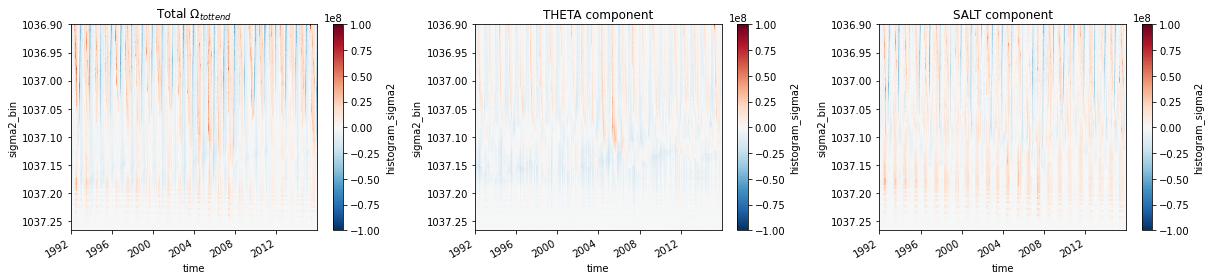

In [59]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0, yincrease=False)
#ax0.set_ylim(ymin=1036.9)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1, yincrease=False)
#ax1.set_ylim(ymin=1036.9)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2, yincrease=False)
#ax2.set_ylim(ymin=1036.9)
ax2.set_title('SALT component')

plt.tight_layout();

Text(0.5, 1.0, 'Total $\\Omega_{tottend}$')

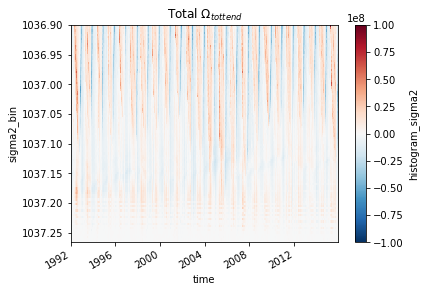

In [60]:
omega_total.plot(x='time', vmax=1e8, yincrease=False)
#plt.ylim(ymax=1037.27, ymin=1036.9)
plt.title(r'Total $\Omega_{tottend}$')

Text(0.5, 1.0, 'New Total $\\Omega_{tottend}$ from `totend_truth`')

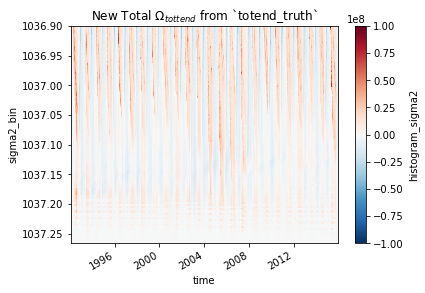

In [48]:
omega_total.plot(x='time', vmax=1e8, yincrease=False)
#plt.ylim(ymax=1037.27, ymin=1036.9)
plt.title(r'New Total $\Omega_{tottend}$ from `totend_truth`')

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

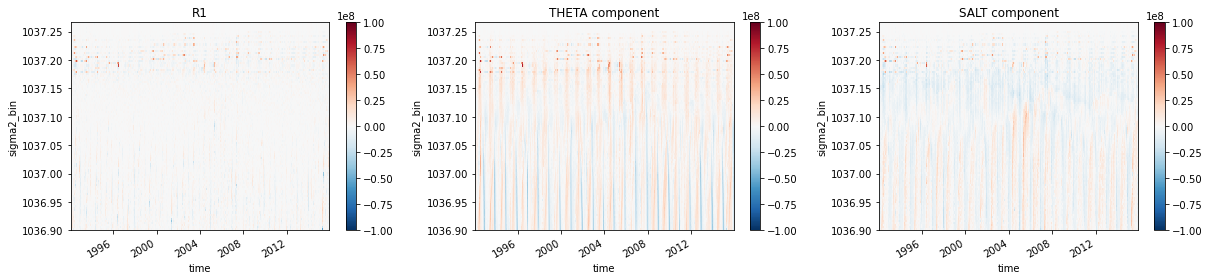

In [61]:
R1 = dVdt - omega_total[1:-1]
R1_th = dVdt - omega_total_th[1:-1]
R1_slt = dVdt - omega_total_slt[1:-1]

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
#ax0.set_ylim(ymin=1036)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
#ax1.set_ylim(ymin=1036)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
#ax2.set_ylim(ymin=1036)
ax2.set_title('SALT component')

plt.tight_layout();

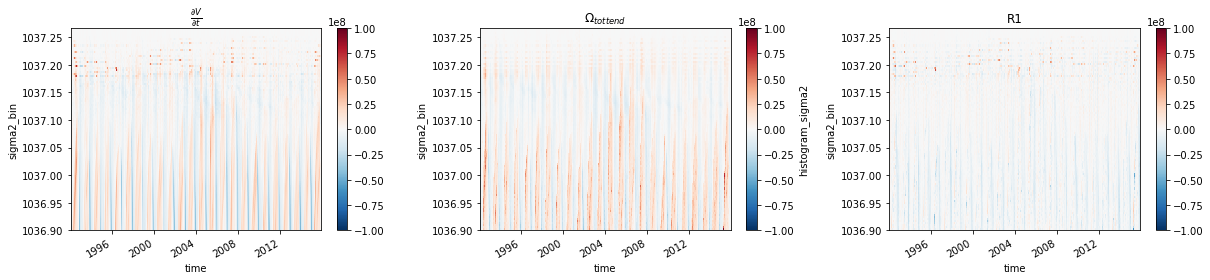

In [49]:
R1 = dVdt - omega_total

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

dVdt.plot(x='time', vmax=1e8, ax=ax0)
#ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title(r'$\frac{\partial{V}}{\partial{t}}$')

omega_total.plot(x='time', vmax=1e8, ax=ax1)
#ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title(r'$\Omega_{tottend}$')

R1.plot(x='time', vmax=1e8, ax=ax2)
#ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('R1')

plt.tight_layout();

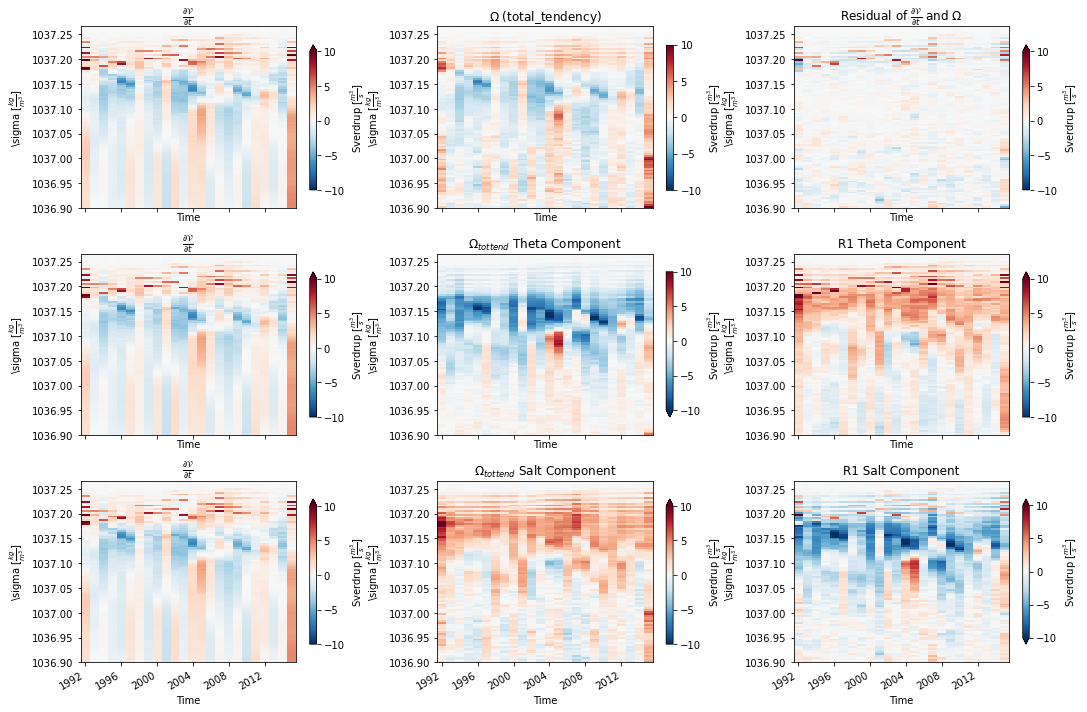

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
axes[0,0].set_xlabel('Time')#, fontsize=14)
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
#axes[0,0].set_ylim(1036.4, 1037.3)

(omega_total[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')#, fontsize=14)
axes[0,1].set_title('$\Omega$ (total_tendency)')
#axes[0,1].set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
#axes[0,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
#axes[1,0].set_ylim(1036.4, 1037.3)

(omega_total_th[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title(r'$\Omega_{tottend}$ Theta Component')
#axes[1,1].set_ylim(1036.4, 1037.3)

(R1_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')#, fontsize=14)
axes[1,2].set_title(r'R1 Theta Component')
#axes[1,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
#axes[2,0].set_ylim(1036.4, 1037.3)

(omega_total_slt[1:-1]/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title(r'$\Omega_{tottend}$ Salt Component')
#axes[2,1].set_ylim(1036.4, 1037.3)

(R1_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')#, fontsize=14)
axes[2,2].set_title(r'R1 Salt Component')
#axes[2,2].set_ylim(1036.4, 1037.3)

plt.tight_layout();

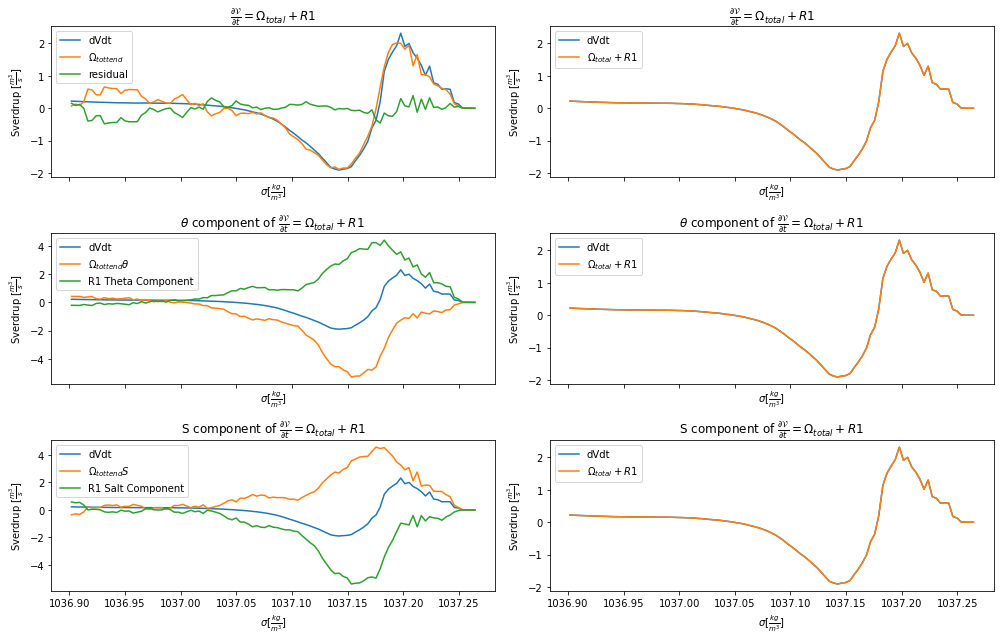

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[0,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
#axes[1,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[1,1].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,0].set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
#axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [21]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['i', 'j', 'k'])
    return hist / (-delta_sigma)

In [22]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [23]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [24]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [27]:
all_dsets_th

<xarray.Dataset>
Dimensions:                        (time: 288, sigma2_bin: 999)
Coordinates:
  * time                           (time) datetime64[ns] 1992-01-15 ... 2015-...
  * sigma2_bin                     (sigma2_bin) float64 1.028e+03 ... 1.037e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_TH   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_TH  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_TH    (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_TH   (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_surface_flux_conv_TH     (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_sw_flux_conv_TH          (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_total_tendency_TH_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

In [25]:
all_dsets_slt

<xarray.Dataset>
Dimensions:           (time: 288, sigma2_bin: 999)
Coordinates:
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin        (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
Data variables:
    OMEGA_G_adv       (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_G_adv_conv  (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_G_diff      (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_G_forc      (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>
    OMEGA_G_tot       (time, sigma2_bin) float64 dask.array<chunksize=(1, 999), meta=np.ndarray>

In [26]:
omega_trans_rate_th = - (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                         all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                         all_dsets_th.OMEGA_sw_flux_conv_TH + 
                         all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

omega_trans_rate_slt = - (all_dsets_slt.OMEGA_G_diff + 
                          all_dsets_slt.OMEGA_G_forc)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        , -7065.50729217,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -3358.78694195, -3734.77088159,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -5737.80932392, -1369.1330103 ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [29]:
test_omega = omega_trans_rate.isel(sigma2_bin=-1) - omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest')
test_omega_slt = omega_trans_rate_slt.isel(sigma2_bin=-1) - omega_trans_rate_slt.sel(sigma2_bin=1037.125, method='nearest')
test_omega_th = omega_trans_rate_th.isel(sigma2_bin=-1) - omega_trans_rate_th.sel(sigma2_bin=1037.125, method='nearest')

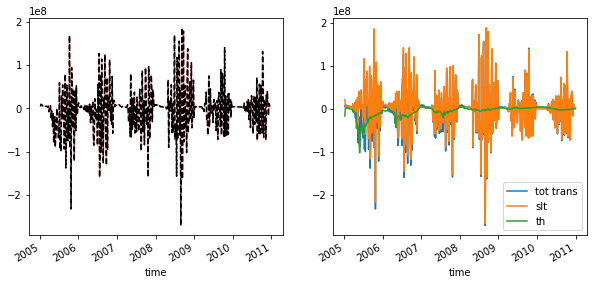

In [30]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

(test_omega_slt+test_omega_th).plot(label='slt+th', ax=ax0, color='pink')
test_omega.plot(label='tot trans', ax=ax0, linestyle='--', color='k')

test_omega.plot(label='tot trans', ax=ax1)
test_omega_slt.plot(label='slt', ax=ax1)
test_omega_th.plot(label='th', ax=ax1)
plt.legend()

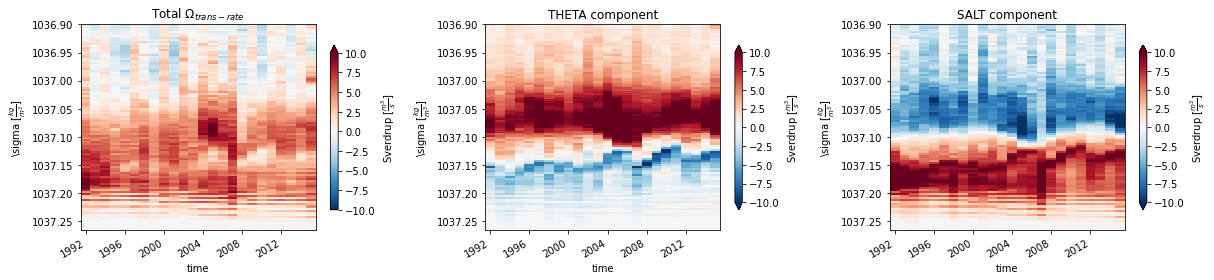

In [71]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.5, 1036)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.5, 1036)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax2.set_ylim(1037.5, 1036)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## Transformation maps sect begin

In [182]:
client.restart()

<Client: 'tls://10.8.1.27:8786' processes=0 threads=0, memory=0 B>

In [42]:
omega_tot_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['k']) / (- delta_sigma)
omega_tot_th

omega_tot_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['k']) / (-delta_sigma)
omega_tot_slt

omega_tot = omega_tot_th + omega_tot_slt
omega_tot

<xarray.DataArray 'histogram_sigma2' (time: 288, j: 50, i: 95, sigma2_bin: 999)>
dask.array<add, shape=(288, 50, 95, 999), dtype=float64, chunksize=(1, 50, 95, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
Dimensions without coordinates: j, i

In [46]:
omega_total.sigma2_bin

<xarray.DataArray 'sigma2_bin' (sigma2_bin: 999)>
array([1027.505, 1027.515, 1027.525, ..., 1037.465, 1037.475, 1037.485])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

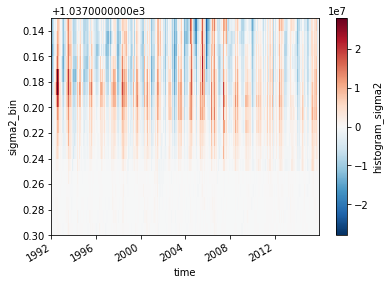

In [51]:
omega_total.sel(sigma2_bin=slice(1037.125, 1037.3)).T.plot(yincrease=False)

In [52]:
np.testing.assert_array_equal(omega_total, omega_tot.sum(['i', 'j']))

AssertionError: 
Arrays are not equal

Mismatched elements: 28218 / 287712 (9.81%)
Max absolute difference: 2.23517418e-07
Max relative difference: 4.04153643e-12
 x: array([[    0.      ,     0.      ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [    0.      ,     0.      ,     0.      , ..., -6845.073021,...
 y: array([[    0.      ,     0.      ,     0.      , ...,     0.      ,
            0.      ,     0.      ],
       [    0.      ,     0.      ,     0.      , ..., -6845.073021,...

In [54]:
test = omega_tot.sum(['i', 'j'])
test.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 999)>
array([[    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -6845.07302107, -2648.78741706,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -9264.73550977,   -55.58460345,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

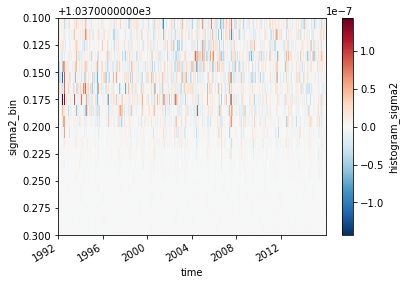

In [59]:
(test - omega_total).sel(sigma2_bin=slice(1037.1, 1037.3)).T.plot(yincrease=False) #residual error

In [99]:
bw_range = omega_tot.sel(sigma2_bin=slice(1037.125, 1037.3))
bw_range

<xarray.DataArray 'histogram_sigma2' (time: 288, j: 50, i: 95, sigma2_bin: 17)>
dask.array<getitem, shape=(288, 50, 95, 17), dtype=float64, chunksize=(1, 50, 95, 17), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
Dimensions without coordinates: j, i

In [104]:
bw = - bw_range.isel(sigma2_bin=-1) + bw_range.isel(sigma2_bin=0)

In [105]:
bw

<xarray.DataArray 'histogram_sigma2' (time: 288, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 95), dtype=float64, chunksize=(1, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i

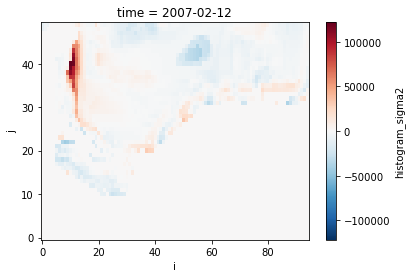

In [118]:
bw.sel(time='2007-02-12').plot()

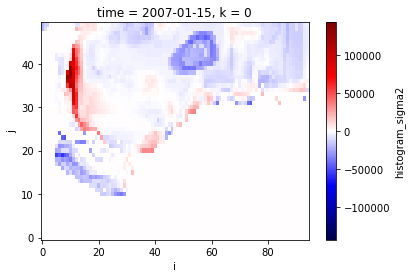

In [144]:
bw.where(mask.isel(k=0))[180].plot(cmap='seismic')

In [150]:
bw_mask = bw.where(mask.isel(k=0))

In [151]:
bw_mask

<xarray.DataArray 'histogram_sigma2' (time: 288, j: 50, i: 95)>
dask.array<where, shape=(288, 50, 95), dtype=float64, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 0
Dimensions without coordinates: j, i

In [64]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [130]:
lon = coords.XC
lat = coords.YC

In [131]:
lon.shape

(50, 95)

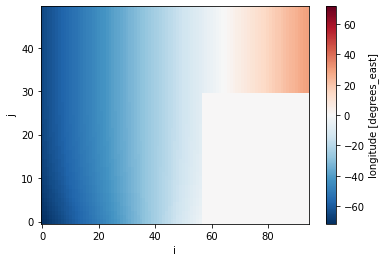

In [132]:
lon.plot()

In [133]:
bw.i.shape

(95,)

In [153]:
client.restart()

<Client: 'tls://10.8.1.27:8786' processes=0 threads=0, memory=0 B>

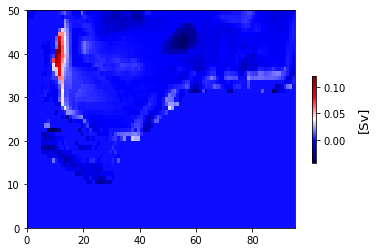

In [154]:
fig, ax = plt.subplots()

im = ax.pcolormesh((bw_mask/1e6).sel(time='2007-02-12'), cmap='seismic')
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

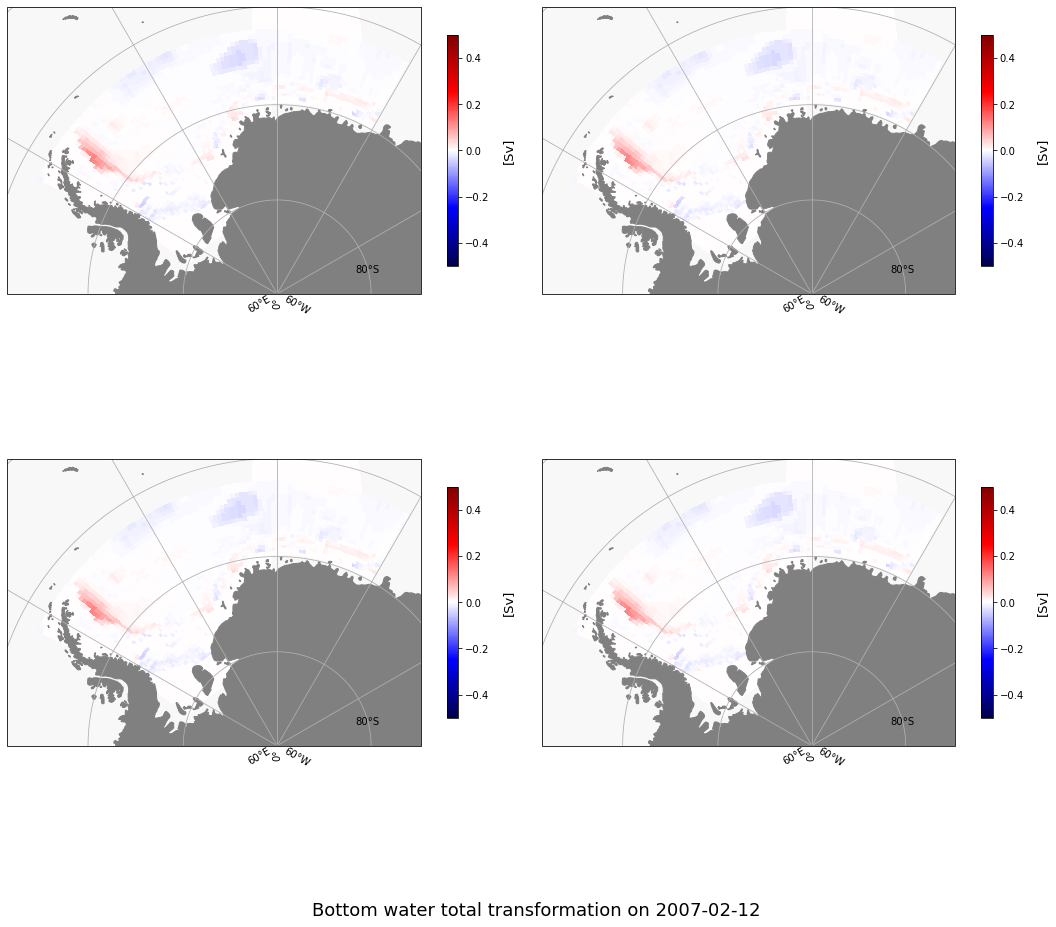

In [181]:
proj = ccrs.SouthPolarStereo() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(2,2, figsize=(15, 15), subplot_kw=dict(projection=proj))

# TOTAL TRANSFORMATION

ax[0,0].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[0,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[0,0].background_patch.set_facecolor('gainsboro')
ax[0,0].background_patch.set_alpha(0.2)

im = ax[0,0].pcolormesh(lon, lat, (bw/1e6).sel(time='2007-02-12'), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[0,0], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax[0,0].text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax[0,0].transAxes, fontsize=12)
#ax[0,0].text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax[0,0].transAxes, fontsize=12)

# MIXING COMPONENT

ax[0,1].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[0,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[0,1].background_patch.set_facecolor('gainsboro')
ax[0,1].background_patch.set_alpha(0.2)

im = ax[0,1].pcolormesh(lon, lat, (bw/1e6).sel(time='2007-02-12'), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[0,1], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

# SURF_SLT COMPONENT

ax[1,0].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[1,0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[1,0].background_patch.set_facecolor('gainsboro')
ax[1,0].background_patch.set_alpha(0.2)

im = ax[1,0].pcolormesh(lon, lat, (bw/1e6).sel(time='2007-02-12'), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[1,0], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

# SURF_TH COMPONENT

ax[1,1].set_extent([-70,30,-90,-60], crs=ccrs.PlateCarree())

ax[1,1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
ax[1,1].background_patch.set_facecolor('gainsboro')
ax[1,1].background_patch.set_alpha(0.2)

im = ax[1,1].pcolormesh(lon, lat, (bw/1e6).sel(time='2007-02-12'), transform=ccrs.PlateCarree(), cmap='seismic', vmin=-0.5, vmax=0.5)
cb = fig.colorbar(im, ax=ax[1,1], shrink=0.4)
cb.set_label("[Sv]", labelpad=12, fontsize=13)

g1 = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.suptitle('Bottom water total transformation on 2007-02-12', fontsize=18, y=0)

plt.tight_layout();

## Transformation maps sect end

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [72]:
psi_adv_th = -(all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()
psi_adv_slt = -(all_dsets_slt.OMEGA_G_adv + all_dsets_slt.OMEGA_G_adv_conv)
psi_adv_slt.load()
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 288, sigma2_bin: 99)>
array([[ -232614.93291505,  -580830.88070767, -1105188.14984961, ...,
          -52971.67389117,  -100870.38829433,  -122184.60665569],
       [-2833145.60189787,  -223534.76605732, -1330798.10707564, ...,
          -93638.12712486,  -218260.70159935,  -160213.39174543],
       [-3304614.46130005, -2411358.33387851, -2384374.83556462, ...,
         -116512.08619087,  -281669.08967284,   -31231.32899435],
       ...,
       [ 2071736.63448308,  -155533.28167355,  3379539.5095811 , ...,
          -58584.18779015,  -239966.13159458,  -227999.20001625],
       [  876526.24131629,  -330468.94529127,  1539526.68106803, ...,
         -154147.8944668 ,  -402126.48249683,   -87987.84300717],
       [-1734079.81293924,  -825760.14686681, -1127698.28102978, ...,
         -228980.40989394,  -142121.11273888,  -106253.54820922]])
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

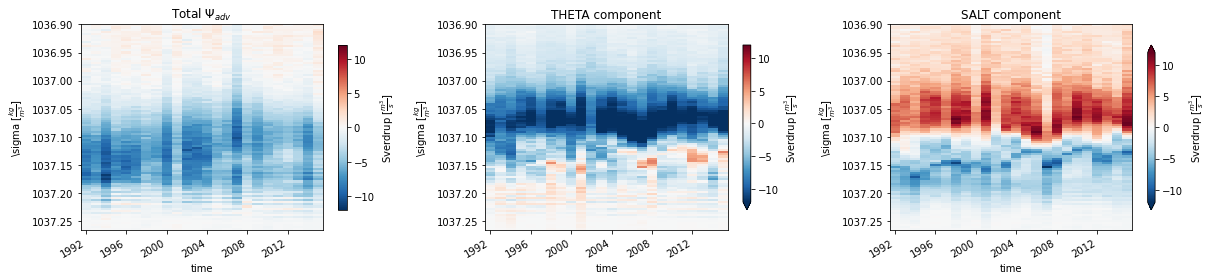

In [73]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12, yincrease=False,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax0.set_ylim(1037.3, 1036.4)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12, yincrease=False,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax1.set_ylim(1037.3, 1036.4)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12, yincrease=False,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
#ax2.set_ylim(1037.3, 1036.4)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

In [58]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(i_g=0)
u_bolus_transport_right = (ds.UVELSTAR * coords.dyG * coords.drF).isel(i_g=-1)
u_bolus_transport_left = (ds.UVELSTAR * coords.dyG * coords.drF).isel(i_g=0)
v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(j_g=-1) #m^3/s #(-) values -> south, (+) values -> north
v_bolus_transport = (ds.VVELSTAR * coords.dxG * coords.drF).isel(j_g=-1)
w_transport = ds.WVEL.isel(k_l=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

In [59]:
u_transport_mean_value = (u_transport_right.sum(dim=['j', 'k']) +
                          u_bolus_transport_right.sum(dim=['j', 'k']) -
                          u_transport_left.sum(dim=['j', 'k']) -
                          u_bolus_transport_left.sum(dim=['j', 'k'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-38.406273, dtype=float32)

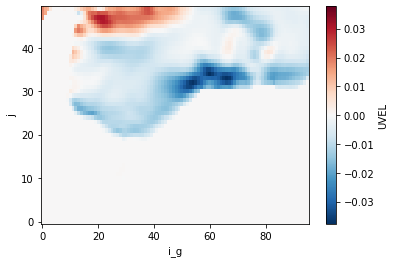

In [67]:
ds.UVEL.mean('time').isel(k=slice(25, -1)).mean('k').plot()

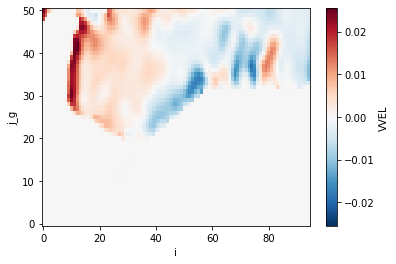

In [68]:
ds.VVEL.mean('time').isel(k=slice(25, -1)).mean('k').plot()

In [76]:
v_transport_mean_value = (v_transport + v_bolus_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(38.4216, dtype=float32)

In [77]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.01507538, dtype=float32)
Coordinates:
    k_l      int64 0

In [78]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual

<xarray.DataArray ()>
array(0.00025208, dtype=float32)
Coordinates:
    k_l      int64 0

In [69]:
# hack theta to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(i=-1)
sigma_at_u_left = sigma2.isel(i=0)
sigma_at_v = sigma2.isel(j=-1)
sigma_at_w = sigma2.isel(k=0)

In [70]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['k', 'j']) 
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['k', 'j'])
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.chunk({'i':-1}), dim=['k', 'i'])
u_bolus_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_bolus_transport_right, dim=['k', 'j']) 
u_bolus_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_bolus_transport_left, dim=['k', 'j'])
v_bolus_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_bolus_transport.chunk({'i':-1}), dim=['k', 'i'])
w_binned = histogram(sigma_at_w.rename('sigma2'), bins=[sigma_bins],
                     weights=w_transport.chunk({'i':-1}), dim=['i', 'j'])

(1036.8, 1037.3)

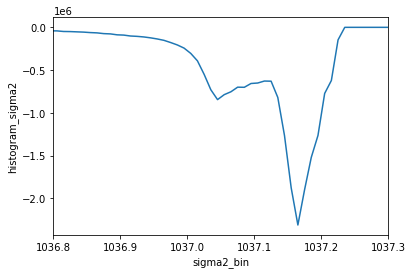

In [73]:
u_binned_right.mean(dim='time').plot()
plt.xlim(1036.8, 1037.3)

In [74]:
#`isel` part is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right + u_bolus_binned_right - 
             u_binned_left - u_bolus_binned_left + 
             v_binned + v_bolus_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 999)>
array([[    -0.    ,     -0.    ,     -0.    , ..., -61548.28  ,
        -61548.28  , -61548.28  ],
       [    -0.    ,     -0.    ,     -0.    , ..., -54672.18  ,
        -54672.18  , -54672.18  ],
       [    -0.    ,     -0.    ,     -0.    , ..., -56381.973 ,
        -56381.973 , -56381.973 ],
       ...,
       [    -0.    ,     -0.    ,     -0.    , ...,  13240.395 ,
         13240.395 ,  13240.395 ],
       [    -0.    ,     -0.    ,     -0.    , ...,   1205.6836,
          1205.6836,   1205.6836],
       [    -0.    ,     -0.    ,     -0.    , ..., -23472.723 ,
        -23472.723 , -23472.723 ]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

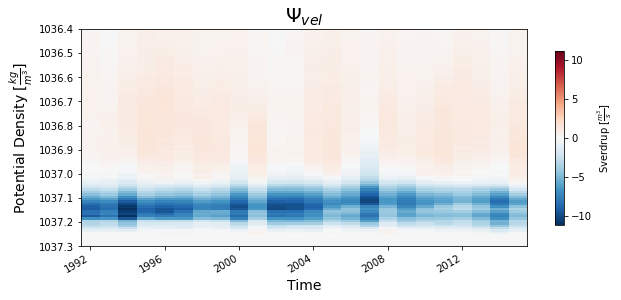

In [76]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1036.4);

In [83]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel_no_bolus = - (u_binned_right - u_binned_left + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel_no_bolus.load()

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 99)>
array([[     -0. ,      -0. ,      -0. , ..., 1953898.1, 1807418.8,
        1827423.4],
       [     -0. ,      -0. ,      -0. , ...,  936695.9,  881066.8,
         870090.5],
       [     -0. ,      -0. ,      -0. , ..., 3174345. , 3085463.2,
        3090658. ],
       ...,
       [     -0. ,      -0. ,      -0. , ..., 1948680.4, 2021794.2,
        1909151.2],
       [     -0. ,      -0. ,      -0. , ..., 2261248.2, 2312380.5,
        2416119. ],
       [     -0. ,      -0. ,      -0. , ..., 1860896.6, 1953185. ,
        1693769.1]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

Text(0.5, 1.0, '$\\Psi_{vel} NO Bolus$')

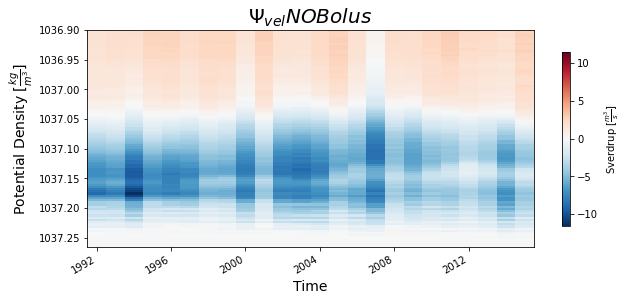

In [84]:
(psi_vel_no_bolus/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel} NO Bolus$', fontsize=20)
#plt.ylim(1037.3, 1036.4);

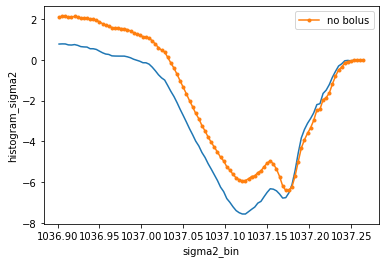

In [85]:
(psi_vel/1e6).mean(dim='time').plot()
(psi_vel_no_bolus/1e6).mean(dim='time').plot(label='no bolus', marker='.')
plt.legend()
#plt.xlim(1035, 1038)

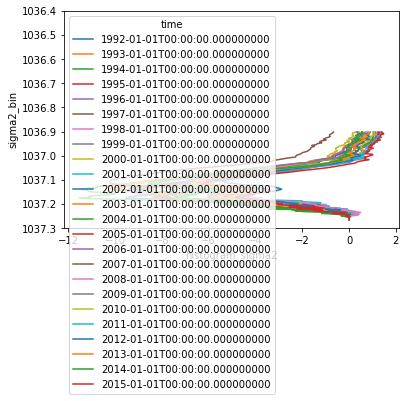

In [86]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin')#, add_legend=False)
plt.ylim(1037.3, 1036.4);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [87]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

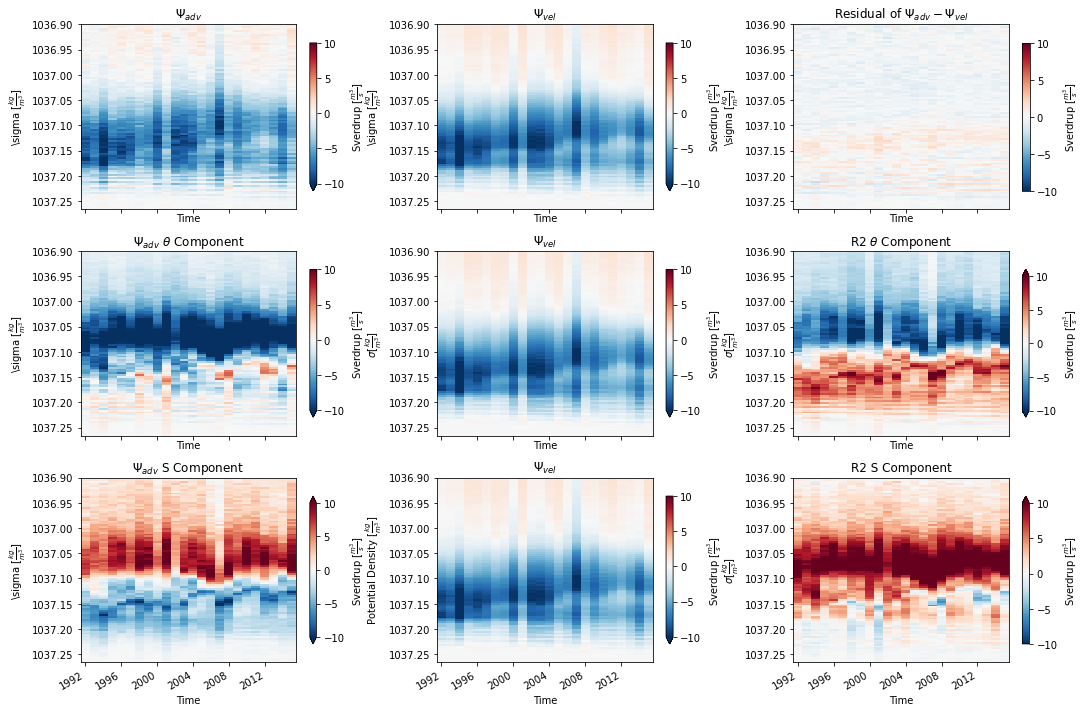

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
#axes[0,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
#axes[0,1].set_ylim(1037.3, 1036.4)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
#axes[0,2].set_ylim(1037.3, 1036.4)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
#axes[1,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
#axes[1,1].set_ylim(1037.3, 1036.4)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
#axes[1,2].set_ylim(1037.3, 1036.4)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10, yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
#axes[2,0].set_ylim(1037.3, 1036.4)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,  yincrease=False,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
#axes[2,1].set_ylim(1037.3, 1036.4)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,  yincrease=False,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
#axes[2,2].set_ylim(1037.3, 1036.4)

plt.tight_layout();

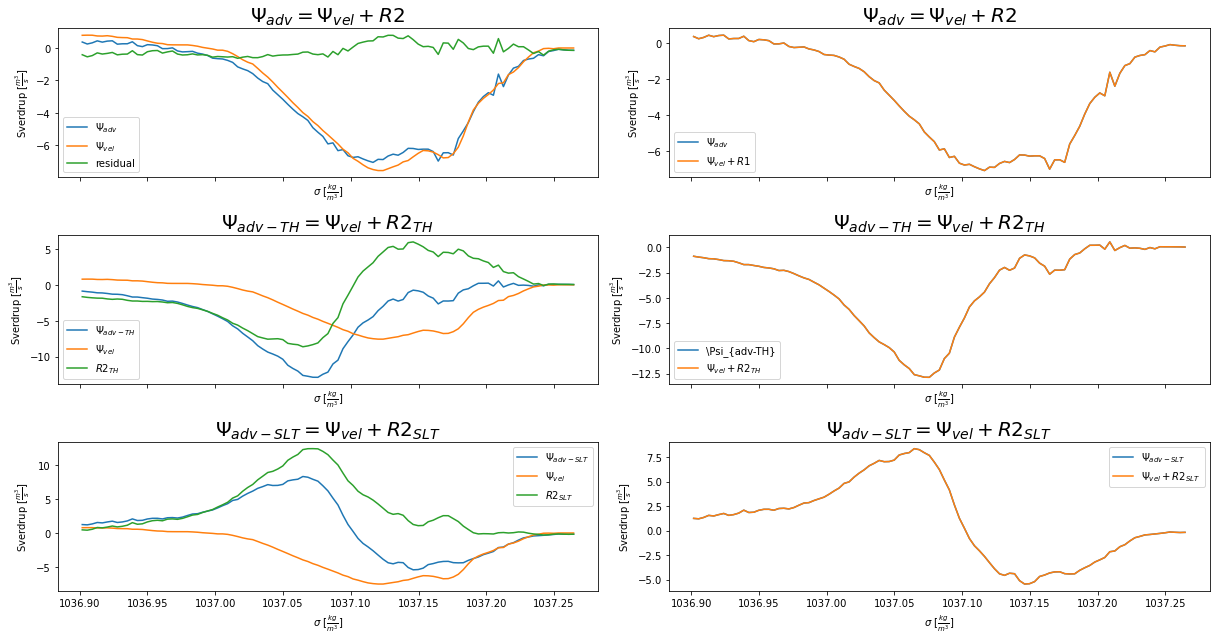

In [89]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,0].set_xlim(1036.4, 1037.3)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
#axes[0,1].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
#axes[1,0].set_xlim(1036.4, 1037.3)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
#axes[1,1].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,0].set_xlim(1036.4, 1037.3)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
#axes[2,1].set_xlim(1036.4, 1037.3)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>

In [90]:
psi_vel.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [91]:
dVdt.coords

Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [92]:
omega_total = omega_total[1:-1]
omega_total_th = omega_total_th[1:-1]
omega_total_slt = omega_total_slt[1:-1]
omega_trans_rate = omega_trans_rate[1:-1]
omega_trans_rate_th = omega_trans_rate_th[1:-1]
omega_trans_rate_slt = omega_trans_rate_slt[1:-1]
psi_adv = psi_adv[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_adv_th = psi_adv_th[1:-1]
psi_vel = psi_vel[1:-1]
R2 = R2[1:-1]

In [93]:
R3_th = omega_total_th - (psi_adv_th + omega_trans_rate_th)
R3_th.load()
R3_slt = omega_total_slt - (psi_adv_slt + omega_trans_rate_slt)
R3_slt.load()
R3 = omega_total - (psi_adv + omega_trans_rate)
R3.load()

<xarray.DataArray (time: 286, sigma2_bin: 99)>
array([[ -9905.68216793, -12128.77530527, -11269.13659855, ...,
         -2587.80403549,  -3687.93848577,  -1488.97103831],
       [ -1174.302886  ,  -1478.69206224,   -238.07971052, ...,
         -3039.05422492,  -2199.51428576,  -1557.83475987],
       [ 35976.82067497,    631.37917079,    499.2808499 , ...,
         -3262.3798355 ,  -2601.79564793,  -1562.40995818],
       ...,
       [  3437.38842266,   4802.0106465 ,  12446.39893735, ...,
         -4754.24666102,  -2660.16175006,  -1499.01834996],
       [ 16443.75731661,  15138.20832725,  14241.19681366, ...,
         -3138.13822616,  -3187.27288914,  -1509.96888037],
       [  1087.71885662,   2444.31646915,    224.49016463, ...,
         -3573.27349096,  -3352.01963834,  -1467.77842518]])
Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

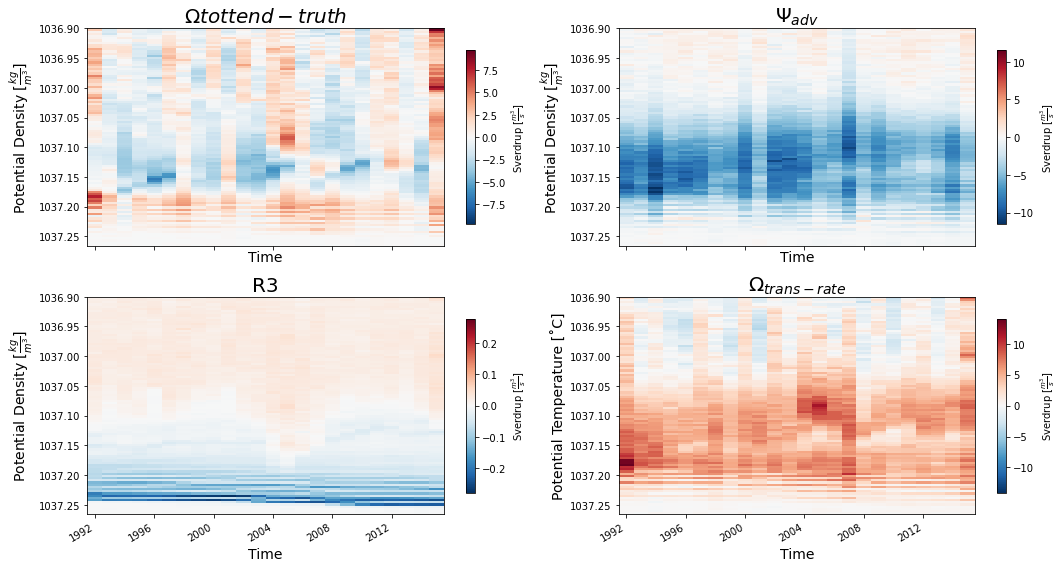

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,0], yincrease=False,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega{tottend-truth}$', fontsize=20)
#ax[0,0].set_ylim(1036.4, 1037.3)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[0,1], yincrease=False, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[0,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('$\Psi_{adv}$', fontsize=20)
#ax[0,1].set_ylim(1036.4, 1037.3)

(R3/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,0], yincrease=False, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,0].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'R3', fontsize=20)
#ax[1,0].set_ylim(1036.4, 1037.3)

(omega_trans_rate/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax[1,1], yincrease=False, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax[1,1].set_ylabel('Potential Temperature [˚C]', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('$\Omega_{trans-rate}$', fontsize=20)
#ax[1,1].set_ylim(1036.4, 1037.3)

plt.tight_layout();

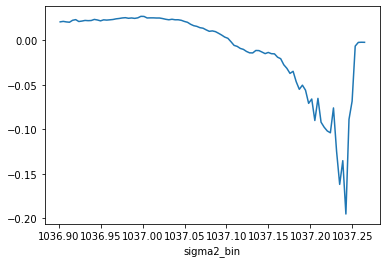

In [95]:
(R3/1e6).mean(dim='time').plot()
#plt.xlim(1035, 1038)

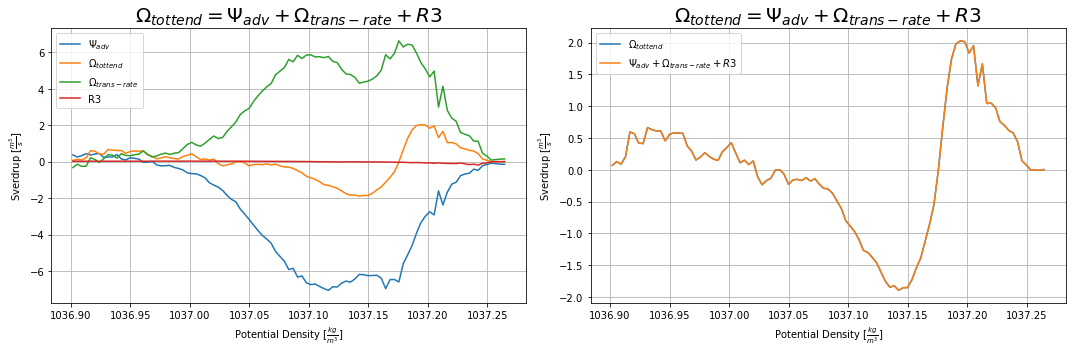

In [96]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax0.set_xlim(1036.4, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_adv + omega_trans_rate + R3)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{adv} + \Omega_{trans-rate} + R3$', fontsize=20)
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

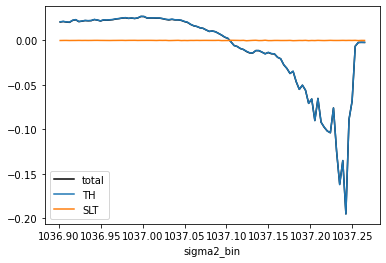

In [97]:
(R3/1e6).mean(dim='time').plot(color='k', label='total')
(R3_th/1e6).mean(dim='time').plot(label='TH')
(R3_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
#plt.xlim(1037.5, 1036.5)

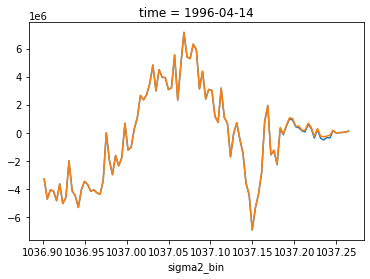

In [98]:
n = 50
omega_total.isel(time=n).plot()
(omega_trans_rate + psi_adv).isel(time=n).plot()

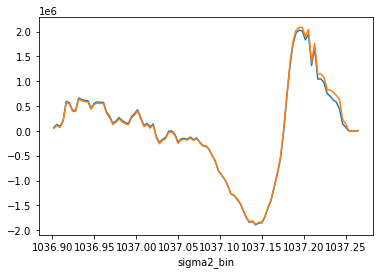

In [99]:
omega_total.mean(dim='time').plot()
(omega_trans_rate + psi_adv).mean(dim='time').plot()
#plt.xlim(1036.4, 1037.3);

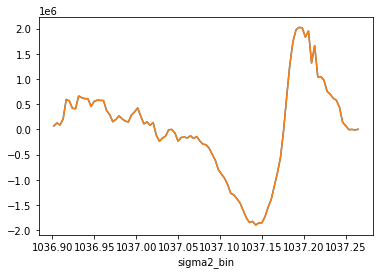

In [100]:
omega_total.mean(dim='time').plot()
(omega_trans_rate + psi_adv + R3).mean(dim='time').plot()
#plt.xlim(1036.4, 1037.3);

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1 \end{equation*} </font>

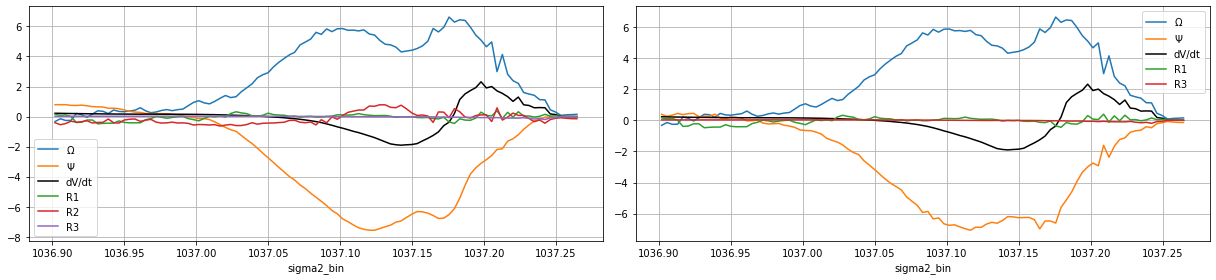

In [101]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', ax=ax1)
(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax1)
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax1)
ax1.legend()
ax1.grid()
#ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

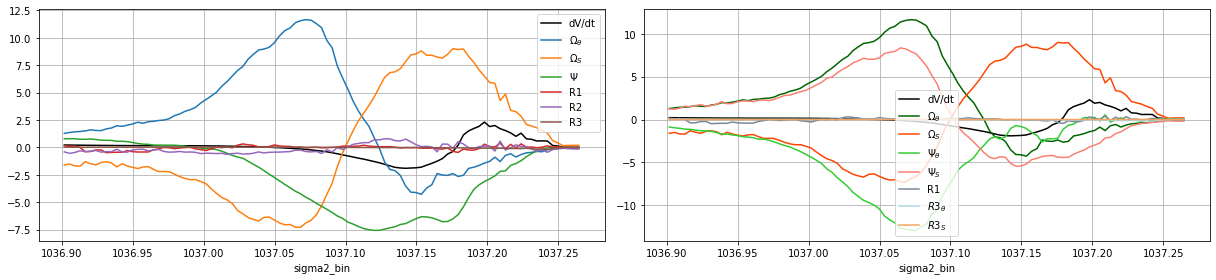

In [102]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax0)
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
(R3/1e6).mean(dim='time').plot(label='R3', ax=ax0)
ax0.legend()
ax0.grid()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', ax=ax1, color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', ax=ax1, color='orangered')
(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{\theta}$', ax=ax1, color='limegreen')
(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_S$', ax=ax1, color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R3_th/1e6).mean(dim='time').plot(label=r'$R3_{\theta}$', ax=ax1, color='lightblue')
(R3_slt/1e6).mean(dim='time').plot(label=r'$R3_S$', ax=ax1, color='sandybrown')
ax1.legend()
ax1.grid()
#ax1.set_xlim(1036.4, 1037.3)
plt.tight_layout();

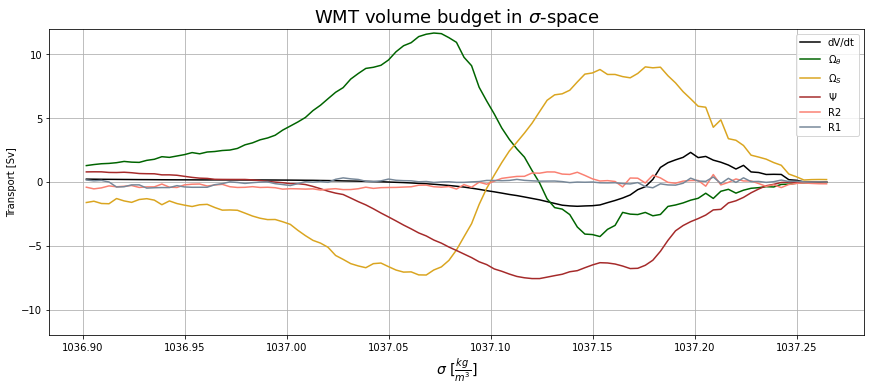

In [103]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='darkgreen')
(omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-12, 12)
#plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$-space', fontsize=18);

ValueError: Could not convert object to NumPy datetime

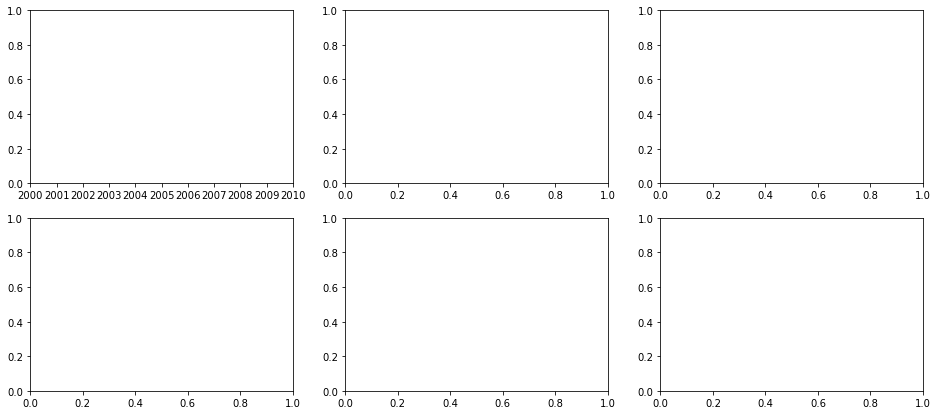

In [113]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))#, sharex=True)

dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6
c = ax[0,0].pcolormesh(dVdt_resampled.time, 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_th_resampled = (omega_trans_rate_th/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,1].pcolormesh(omega_th_resampled.time, omega_th_resampled.sigma2_bin, omega_th_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Omega_{\theta}$', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_slt_resampled = (omega_trans_rate_slt/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,2].pcolormesh(omega_slt_resampled.time, omega_slt_resampled.sigma2_bin, omega_slt_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,2].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega_{S}$', fontsize=20)
ax[0,2].set_ylim(1037.3, 1036.3)
ax[0,2].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(R1_resampled.time, R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(psi_vel_resampled.time, psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c4 = ax[1,2].pcolormesh(R2_resampled.time, R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c4, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title('R2', fontsize=20)
ax[1,2].set_ylim(1037.3, 1036.3)
ax[1,2].grid()
plt.tight_layout();

In [98]:
dVdt_resampled = dVdt.resample(time='AS').mean(dim='time') / 1e6

<ipython-input-99-4f6fa1e9d5ad>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = plt.pcolormesh(dVdt_resampled.time,


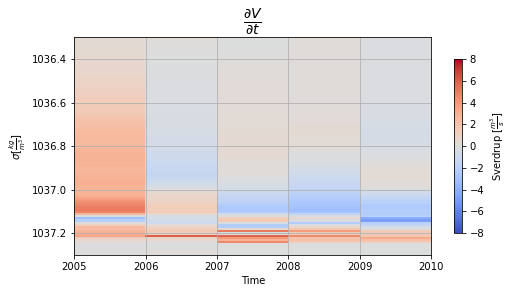

In [99]:
plt.figure(figsize=(8,4))
c = plt.pcolormesh(dVdt_resampled.time, 
                   dVdt_resampled.sigma2_bin, 
                   dVdt_resampled.T, vmin=-8, vmax=8, cmap='coolwarm')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$')
plt.grid()
plt.ylabel(r'$\sigma [\frac{kg}{m^3}]$')
plt.xlabel('Time')
plt.title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
plt.ylim(1037.3, 1036.3);

In [86]:
dVdt_resampled.differentiate(coord='sigma2_bin')

<xarray.DataArray (time: 24, sigma2_bin: 999)>
dask.array<_trim, shape=(24, 999), dtype=float64, chunksize=(1, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1992-01-01 1993-01-01 ... 2015-01-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

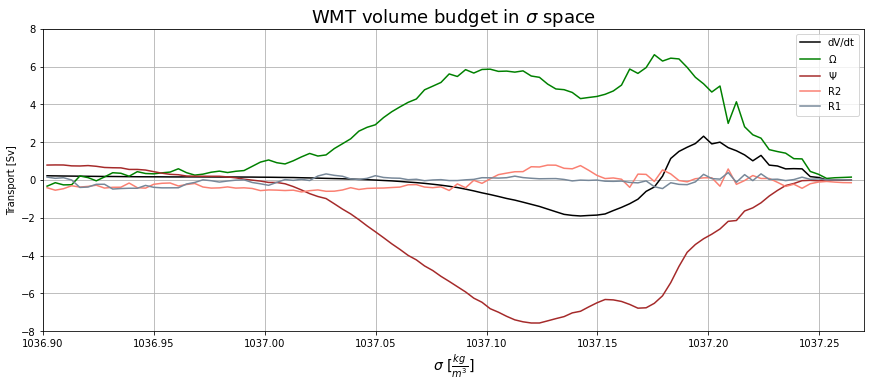

In [104]:
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.xlim(1036.9, 1037.27)
plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

ValueError: Could not convert object to NumPy datetime

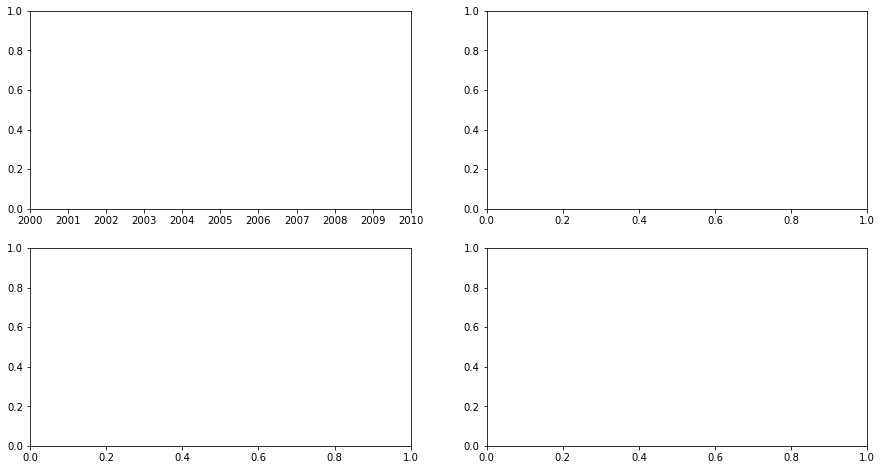

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))#, sharex=True)

omega_resampled = (omega_trans_rate/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,0].pcolormesh(omega_resampled.time, omega_resampled.sigma2_bin, omega_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

psi_vel_resampled = (psi_vel/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,1].pcolormesh(psi_vel_resampled.time, psi_vel_resampled.sigma2_bin, psi_vel_resampled.T,
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi$', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

R1_resampled = (R1/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(R1_resampled.time, R1_resampled.sigma2_bin, R1_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('R1', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

R2_resampled = (R2/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(R2_resampled.time, R2_resampled.sigma2_bin, R2_resampled.T,
                             cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('R2', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()
plt.tight_layout();

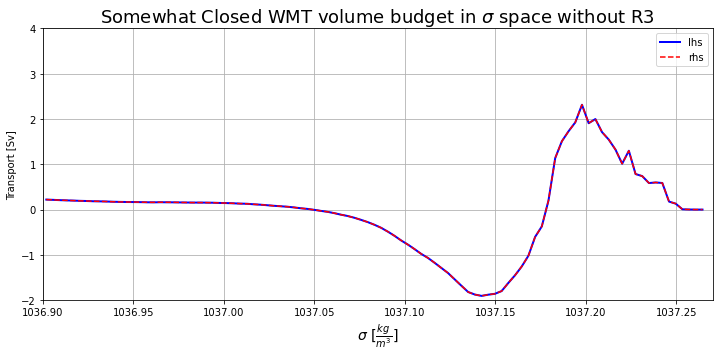

In [105]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1 + R3)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Somewhat Closed WMT volume budget in $\sigma$ space without R3', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-2.0,4.0)
plt.xlim(1036.9, 1037.27);

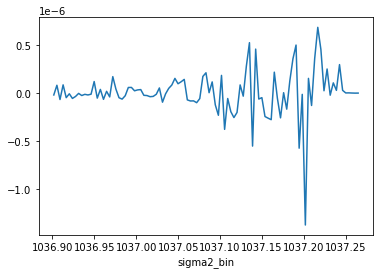

In [109]:
((dVdt/1e6).mean(dim='time') - ((omega_trans_rate + psi_adv + R1 + R3)/1e6).mean(dim='time')).plot()

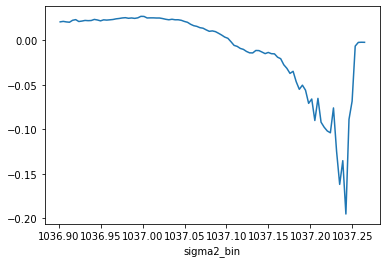

In [111]:
(R3/1e6).mean(dim='time').plot()

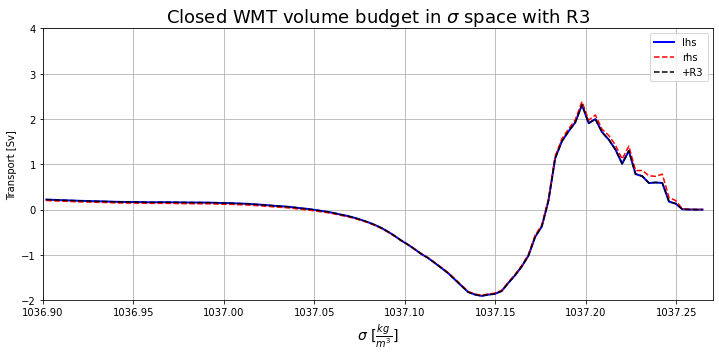

In [106]:
(dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
((omega_trans_rate + psi_adv + R1 +R3)/1e6).mean(dim='time').plot(color='k', linestyle='dashed', label='+R3')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space with R3', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-2.0,4.0)
plt.xlim(1036.9, 1037.27);

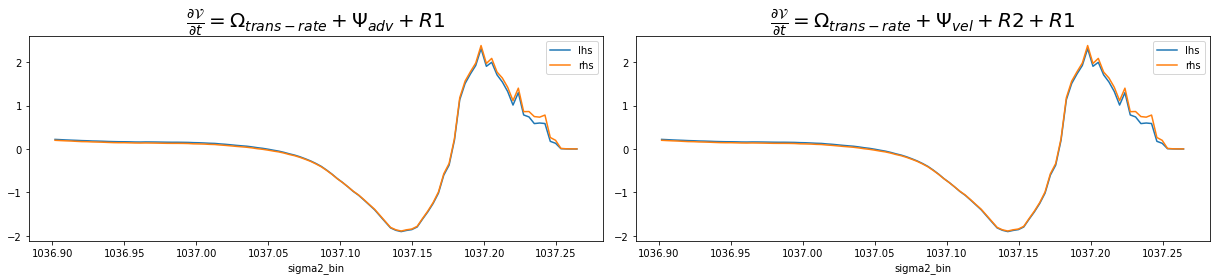

In [107]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

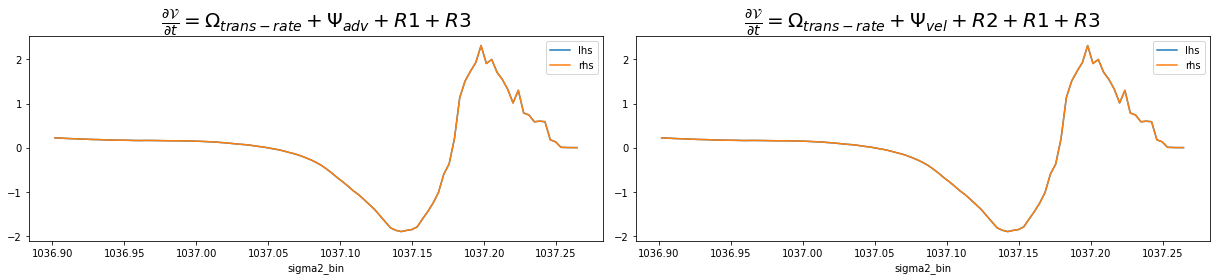

In [108]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_trans_rate + psi_adv + R1+R3)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1 + R3$', fontsize=20, fontweight='bold')
ax0.legend()
#ax0.set_xlim(1036.4, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((omega_trans_rate + R1 + psi_vel + R2+R3)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{vel} + R2 + R1 + R3$', fontsize=20, fontweight='bold')
ax1.legend()
#ax1.set_xlim(1036.4, 1037.3)

plt.tight_layout();

## Saving WMT budget terms to netcdf

In [133]:
omega_trans_rate.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [132]:
dVdt.coords

Coordinates:
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [134]:
psi_adv.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [135]:
omega_surf[1:-1].coords

Coordinates:
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [141]:
omega_mix.coords

Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

In [122]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), R1.rename('R1'), 
                             omega_total.rename('omega_total'),
                             omega_total_th.rename('omega_total_th'),
                             omega_total_slt.rename('omega_total_slt'),
                             psi_adv.rename('psi_adv'),
                             psi_vel.rename('psi_vel'), R2.rename('R2'), 
                             omega_trans_rate.rename('omega_trans_rate'),
                             omega_trans_rate_th.rename('omega_trans_rate_th'),
                             omega_trans_rate_slt.rename('omega_trans_rate_slt'), R3.rename('R3'),
                             omega_surf[1:-1].rename('omega_surf'),
                             omega_surf_slt[1:-1].rename('omega_surf_slt'),
                             omega_surf_th[1:-1].rename('omega_surf_th'), 
                             omega_mix[1:-1].rename('omega_mix'), 
                             omega_mix_th[1:-1].rename('omega_mix_th'),
                             omega_mix_slt[1:-1].rename('omega_mix_slt')])

In [123]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (sigma2_bin: 99, time: 286)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
Data variables: (12/18)
    dVdt                  (time, sigma2_bin) float32 dask.array<chunksize=(286, 99), meta=np.ndarray>
    R1                    (time, sigma2_bin) float64 dask.array<chunksize=(286, 99), meta=np.ndarray>
    omega_total           (time, sigma2_bin) float64 -1.337e+07 ... -3.438e+04
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_total_slt       (time, sigma2_bin) float64 -5.002e+06 ... -5.252e+04
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    ...                    ...
    omega_surf            (time, sigma2_bin) float64 -1.282e+06 ... 5.805e+04
    omega_surf_slt        (time, sigma2_bin) float64 4.602e+05 ... 5.805e+04
    omega_surf_th         (time, sigma2_bin) float64 -1.743e+06 ... 0.0
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_th          (time, sigma2_bin) float64 -6.14e+06 ... 6.008e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03

In [154]:
dVdt.time.coords

Coordinates:
    time_snp  (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
  * time      (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [162]:
omega_total_slt.time.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [113]:
R2.time.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [157]:
omega_surf[1:-1].time.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [158]:
omega_mix[1:-1].time.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [50]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [51]:
omega_total = omega_total.to_dataset(name='omega_total')

In [52]:
R1 = R1.to_dataset(name='R1')

In [54]:
#uploading new totend as dsigma2_dt
gcsmap_omega_total = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/omega_total_newbins.zarr')
omega_total.to_zarr(gcsmap_omega_total, mode='w')

In [55]:
#uploading new R1 for new totend as dsigma2_dt
gcsmap_R1 = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/R1_newbins.zarr')
R1.to_zarr(gcsmap_R1, mode='w')

In [125]:
# uploading to cloud instead of here bc I can't `to_netcdf` w workers on
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms_newbins.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [4]:
client

<Client: 'tls://10.37.103.45:8786' processes=1 threads=2, memory=8.59 GB>

In [148]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 288, sigma2_bin: 99)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
    time_snp              (time) datetime64[ns] NaT 1992-03-01 ... NaT
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    R2                    (time, sigma2_bin) float64 -5.467e+05 ... -1.063e+05
    R3                    (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    dVdt                  (time, sigma2_bin) float32 nan nan nan ... nan nan nan
    omega_mix             (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_mix_slt         (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate      (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_slt  (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_adv               (time, sigma2_bin) float64 nan nan nan ... nan nan nan
    psi_vel               (time, sigma2_bin) float32 nan nan nan ... nan nan nan

(-2.0, 4.0)

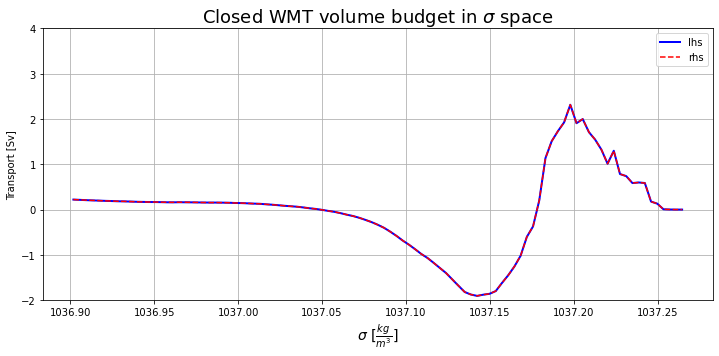

In [151]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='lhs', color='blue', linewidth=2, figsize=(12,5)) 
((wmt_budget_terms.omega_trans_rate 
  + wmt_budget_terms.psi_adv 
  + wmt_budget_terms.R1
  + wmt_budget_terms.R3)/1e6).mean(dim='time').plot(color='red', linestyle='dashed', label='rhs')
#plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + \Psi + R3 + R1$', fontsize=18)
plt.title(r'Closed WMT volume budget in $\sigma$ space', fontsize=18)
plt.legend()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.grid()
plt.ylim(-2.0,4.0)
#plt.xlim(1035.5, 1037.5);

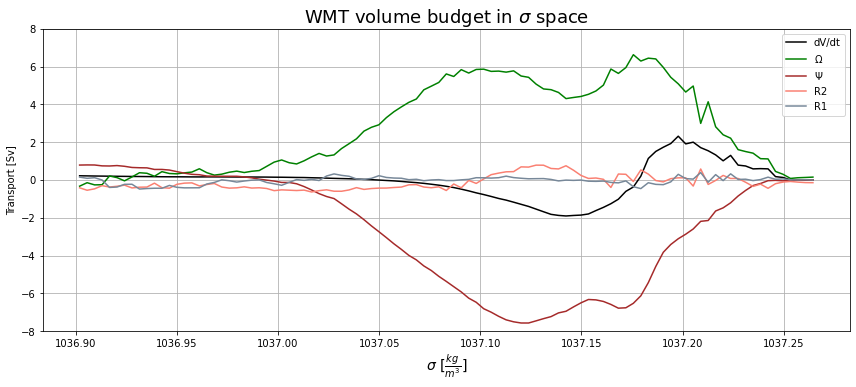

In [152]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 8)
plt.tight_layout()
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);

In [6]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=12).mean(dim='time')
    return anom_rolled

In [7]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'), wmt_budget_terms.R1.rename('R1'), 
                    wmt_budget_terms.psi_vel.rename('psi_vel'), wmt_budget_terms.R2.rename('R2'), 
                    wmt_budget_terms.omega_trans_rate.rename('omega_trans_rate'), 
                    wmt_budget_terms.omega_surf_slt.rename('omega_surf_slt'),
                    wmt_budget_terms.omega_surf_th.rename('omega_surf_th'), 
                    wmt_budget_terms.omega_mix.rename('omega_mix')])


In [8]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [9]:
clim_ds = anom_ds

In [11]:
anom_ds

<xarray.Dataset>
Dimensions:           (sigma2_bin: 999, time: 72)
Coordinates:
  * sigma2_bin        (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time              (time) datetime64[ns] 2005-01-15 2005-02-12 ... 2010-12-15
    time_snp          (time) datetime64[ns] NaT 2005-03-01 ... 2010-12-01 NaT
Data variables:
    dVdt              (time, sigma2_bin) float64 nan nan nan nan ... nan nan nan
    R1                (time, sigma2_bin) float64 nan nan nan nan ... nan nan nan
    psi_vel           (time, sigma2_bin) float64 nan nan nan nan ... nan nan nan
    R2                (time, sigma2_bin) float64 1.792e+05 1.792e+05 ... 0.0 0.0
    omega_trans_rate  (time, sigma2_bin) float64 nan nan nan nan ... nan nan nan
    omega_surf_slt    (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th     (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_mix         (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

<ipython-input-6-ccc80b1ba90e>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=12).mean(dim='time')
<ipython-input-10-5af3734adc2c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax[0,0].pcolormesh(dVdt_anom_rolled.time,


ConversionError: Failed to convert value(s) to axis units: '2005'

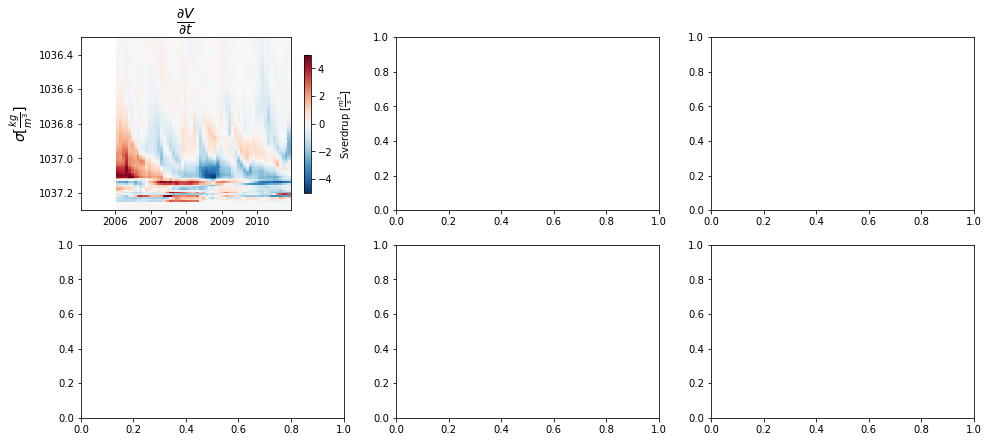

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))#, sharex=True)

dVdt_anom_rolled = anom(anom_ds.dVdt) / 1e6
c = ax[0,0].pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].set_xlim(xmin='2005')
ax[0,0].grid()

psi_vel_anom_rolled = anom(anom_ds.psi_vel) / 1e6
c_psi = ax[0,1].pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].set_xlim(xmin='2005')
ax[0,1].grid()

omega_anom_rolled = anom(anom_ds.omega_trans_rate) /1e6
c_omega = ax[0,2].pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].set_ylim(1037.3, 1036.3)
ax[0,2].set_xlim(xmin='2005')
ax[0,2].grid()

omega_surf_slt_anom_rolled = anom(anom_ds.omega_surf_slt)/1e6
c_surf_slt = ax[1,0].pcolormesh(omega_surf_slt_anom_rolled.time, 
                                omega_surf_slt_anom_rolled.sigma2_bin, 
                                omega_surf_slt_anom_rolled.T, vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].set_xlim(xmin='2005')
ax[1,0].grid()

omega_surf_th_anom_rolled = anom(anom_ds.omega_surf_th) /1e6
c_surf_th = ax[1,1].pcolormesh(omega_surf_th_anom_rolled.time, omega_surf_th_anom_rolled.sigma2_bin, 
                        omega_surf_th_anom_rolled.T, vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].set_xlim(xmin='2005')
ax[1,1].grid()

omega_mix_anom_rolled = anom(anom_ds.omega_mix) / 1e6
c_mix = ax[1,2].pcolormesh(omega_mix_anom_rolled.time, omega_mix_anom_rolled.sigma2_bin, omega_mix_anom_rolled.T, 
                        vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].set_ylim(1037.3, 1036.3)
ax[1,2].set_xlim(xmin='2005')
ax[1,2].grid()

plt.tight_layout();

<ipython-input-134-ccc80b1ba90e>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=12).mean(dim='time')
<ipython-input-140-9c1fddb97a73>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  r1 = ax0.pcolormesh(R1_anom_rolled.time, R1_anom_rolled.sigma2_bin,
<ipython-input-134-ccc80b1ba90e>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom.rolling(time=12).mean(dim='time')
<ipython-input-140-9c1fddb97a73>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have t

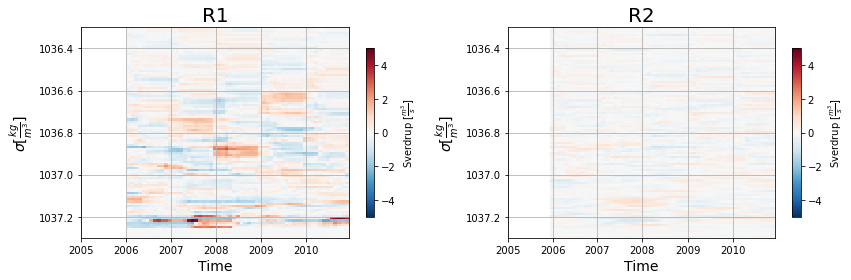

In [140]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

R1_anom_rolled = anom(anom_ds.R1)/1e6
r1 = ax0.pcolormesh(R1_anom_rolled.time, R1_anom_rolled.sigma2_bin, 
                        R1_anom_rolled.T, vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(r1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'R1', fontsize=20)
ax0.set_ylim(1037.3, 1036.3)
ax0.set_xlim(xmin='2005')
ax0.grid()

R2_anom_rolled = anom(anom_ds.R2)/1e6
r2 = ax1.pcolormesh(R2_anom_rolled.time, R2_anom_rolled.sigma2_bin, 
                        R2_anom_rolled.T, vmin=-5, vmax=5, cmap='RdBu_r')
plt.colorbar(r2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax1)
ax1.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title(r'R2', fontsize=20)
ax1.set_ylim(1037.3, 1036.3)
ax1.set_xlim(xmin='2005')
ax1.grid()

plt.tight_layout();

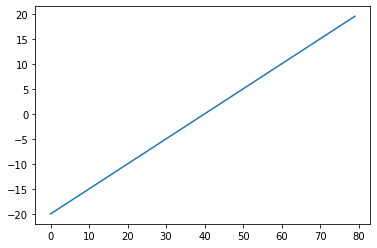

In [204]:
plt.plot(np.arange(-20, 20, 0.5))

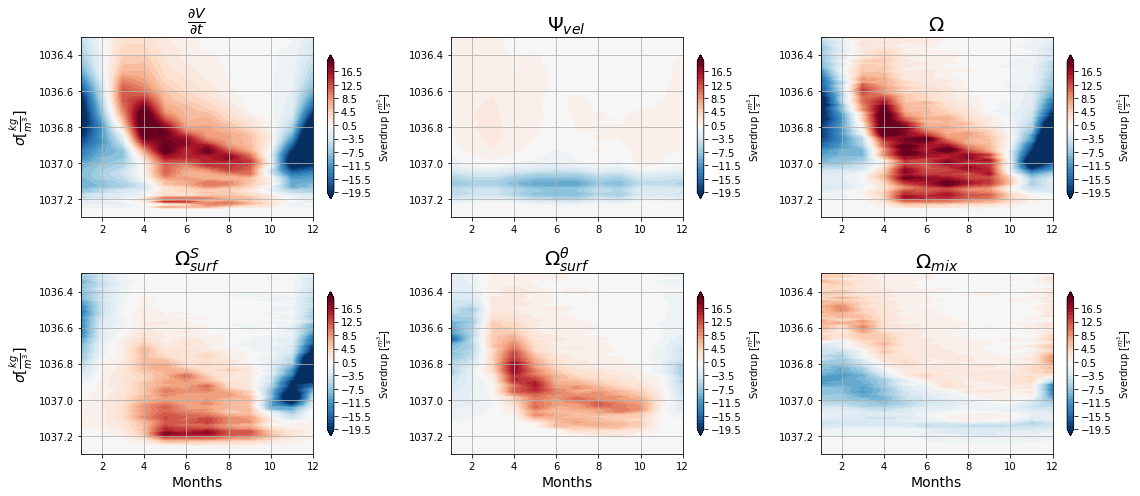

In [143]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7))#, sharex=True)

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
#ax[0,0].set_xlim(xmin='1993')
ax[0,0].grid()

psi_vel_clim = clim(clim_ds.psi_vel) / 1e6
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
#ax[0,1].set_xlim(xmin='1993')
ax[0,1].grid()

omega_clim = clim(clim_ds.omega_trans_rate) /1e6
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].set_ylim(1037.3, 1036.3)
#ax[0,2].set_xlim(xmin='1993')
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)/1e6
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Months', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
#ax[1,0].set_xlim(xmin='1993')
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th) /1e6
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
#ax[1,1].set_xlim(xmin='1993')
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix) / 1e6
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='RdBu_r', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].set_ylim(1037.3, 1036.3)
#ax[1,2].set_xlim(xmin='1993')
ax[1,2].grid()

plt.tight_layout();

In [144]:
client.close()
cluster.close()

## Trying to locate HSSW

In [288]:
hssw_location = (sigma2 > 1037.25).astype(int).mean('time') * vol

In [289]:
hssw_location

<xarray.DataArray (k: 50, j: 50, i: 95)>
dask.array<mul, shape=(50, 50, 95), dtype=float64, chunksize=(50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [296]:
hssw_j_cross_sec_view = hssw_location.mean(dim='i').load()
hssw_i_cross_sec_view = hssw_location.mean(dim='j').load()

In [291]:
hssw_j_cross_sec_view

<xarray.DataArray (k: 50, j: 50)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.43680069e+09, 5.66175332e+09, 7.25200258e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j

In [292]:
hssw_mask = hssw_location.where((sigma2 < 1037.25).astype(int).mean(['time']))
hssw_mask_j_cross_sec_view = hssw_mask.mean(dim='i').load()
hssw_mask_i_cross_sec_view = hssw_mask.mean(dim='j').load()

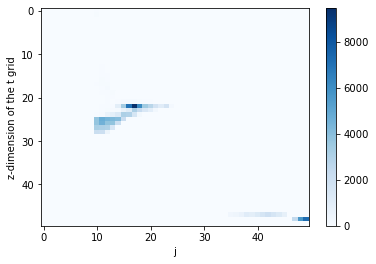

In [294]:
(hssw_j_cross_sec_view/1e6).plot(yincrease=False, cmap='Blues')

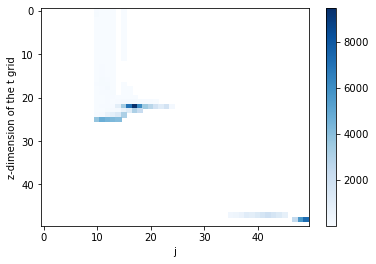

In [297]:
(hssw_j_cross_sec_view.where(hssw_mask_j_cross_sec_view)/1e6).plot(yincrease=False, cmap='Blues')

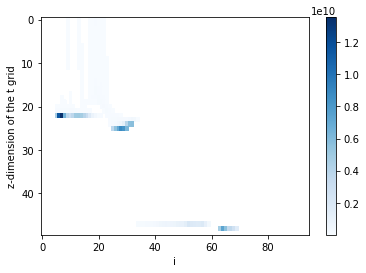

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/noteboo

In [298]:
hssw_i_cross_sec_view.where(hssw_mask_i_cross_sec_view).plot(yincrease=False, cmap='Blues')

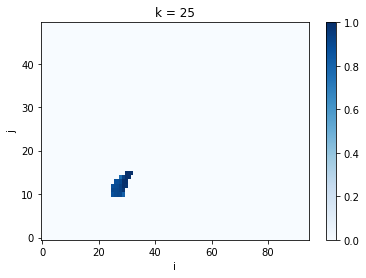

In [287]:
hssw_location[25].plot(cmap='Blues')

In [266]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

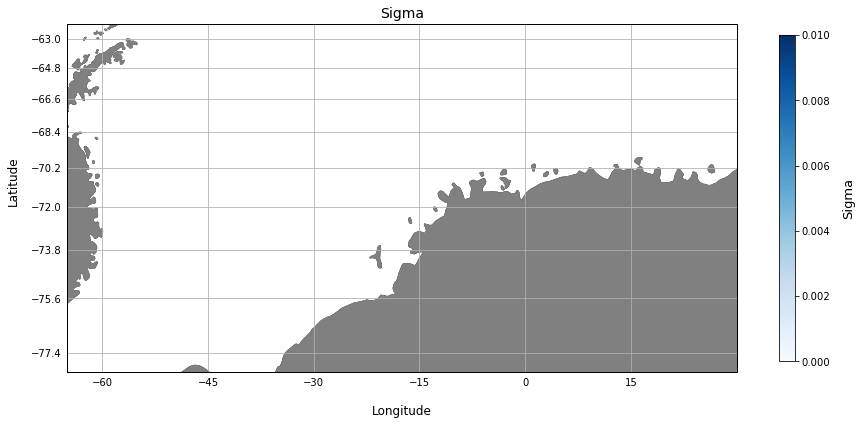

In [276]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(hssw_location.i, 
                   hssw_location.j, 
                   hssw_location[22], 
                   transform=ccrs.PlateCarree(), cmap='Blues', vmax=0.01)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Sigma", labelpad=12, fontsize=13)

plt.contourf(hssw_location.i, 
            hssw_location.j, 
            hssw_location[0],
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Sigma", fontsize=14);

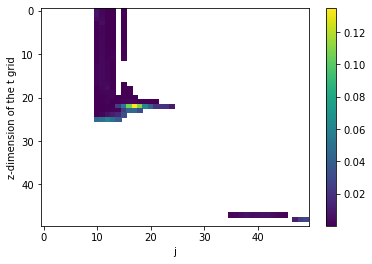

In [259]:
hssw.where(hssw_mask).plot(yincrease=False)

In [218]:
wmt_budget_terms.omega_total

<xarray.DataArray 'omega_total' (time: 288, sigma2_bin: 999)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [    0.        ,     0.        ,     0.        , ...,
        -6845.07302107, -2648.78741706,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
        -9264.73550977,   -55.58460345,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp    (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT

In [216]:
wmt_budget_terms.omega_total.mean(dim='time').where(hssw_location)#.plot()

<xarray.DataArray 'omega_total' (sigma2_bin: 999, k: 50, j: 50, i: 95)>
dask.array<where, shape=(999, 50, 50, 95), dtype=float64, chunksize=(999, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

(array([  3176.,    794.,   1588.,   3970., 734450.,  39700.,   5558.,
           794.,   1588.,   1588.]),
 array([-1888482.34596373, -1496110.8388319 , -1103739.33170007,
         -711367.82456824,  -318996.31743641,    73375.18969542,
          465746.69682725,   858118.20395908,  1250489.71109091,
         1642861.21822274,  2035232.72535457]),
 <a list of 10 Patch objects>)

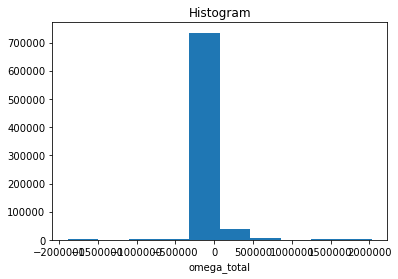

In [215]:
wmt_budget_terms.omega_total.mean(dim='time').where(hssw_location).plot()

## Breaking up $\Omega_{trans-rate}$ term

In [114]:
omega_mix_th = (- (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                  all_dsets_th.OMEGA_conv_vert_diff_flux_TH)).load()
omega_surf_th = (-(all_dsets_th.OMEGA_sw_flux_conv_TH + 
                  all_dsets_th.OMEGA_surface_flux_conv_TH)).load()

omega_mix_slt = (-all_dsets_slt.OMEGA_G_diff).load()
omega_surf_slt = (- all_dsets_slt.OMEGA_G_forc).load()

omega_mix = (omega_mix_th + omega_mix_slt).load()
omega_surf = (omega_surf_th + omega_surf_slt).load()

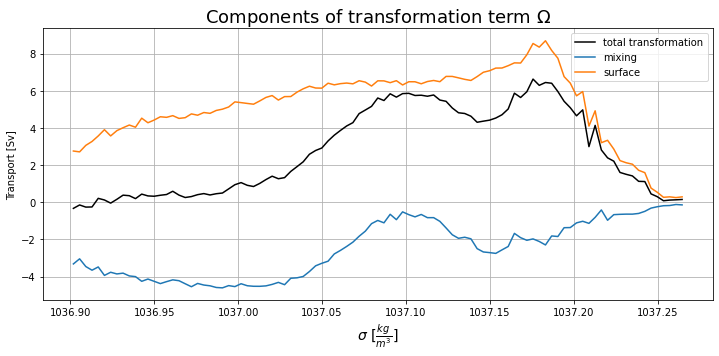

In [115]:
(omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')
(omega_mix/1e6).mean(dim='time').plot(label='mixing')
(omega_surf/1e6).mean(dim='time').plot(label='surface')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Components of transformation term $\Omega$', fontsize=18);

NameError: name 'omega_resampled' is not defined

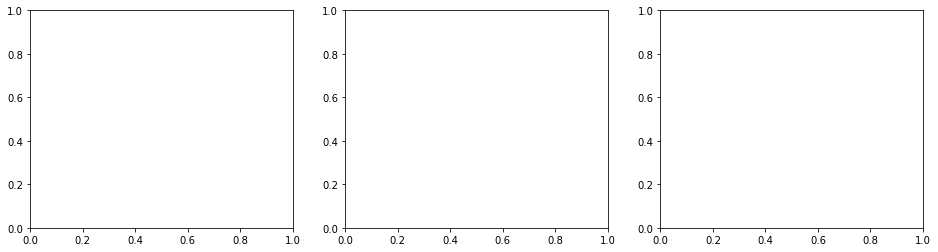

In [121]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4))#, sharex=True)

c0 = ax0.pcolormesh(omega_resampled.time, omega_resampled.sigma2_bin, omega_resampled.T, 
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\Omega$', fontsize=20)
#ax0.set_ylim(1037.3, 1036.3)
ax0.grid()

omega_mix_resampled = (omega_mix/1e6).resample(time='AS').mean(dim='time')
c1 = ax1.pcolormesh(omega_mix_resampled.time, omega_mix_resampled.sigma2_bin, omega_mix_resampled.T, 
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax1)
ax1.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Omega_{mix}$', fontsize=20)
#ax1.set_ylim(1037.3, 1036.3)
ax1.grid()

omega_surf_resampled = (omega_surf/1e6).resample(time='AS').mean(dim='time')
c2 = ax2.pcolormesh(omega_surf_resampled.time, omega_surf_resampled.sigma2_bin, omega_surf_resampled.T, 
                        cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
ax2.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega_{surf}$', fontsize=20)
#ax2.set_ylim(1037.3, 1036.3)
ax2.grid()

plt.tight_layout();

In [ ]:
(omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Temperature and salinity components of transformation term $\Omega$', fontsize=18);

In [117]:
omega_mix_th_resampled = (omega_mix_th/1e6).resample(time='AS').mean(dim='time')

In [118]:
import pandas as pd

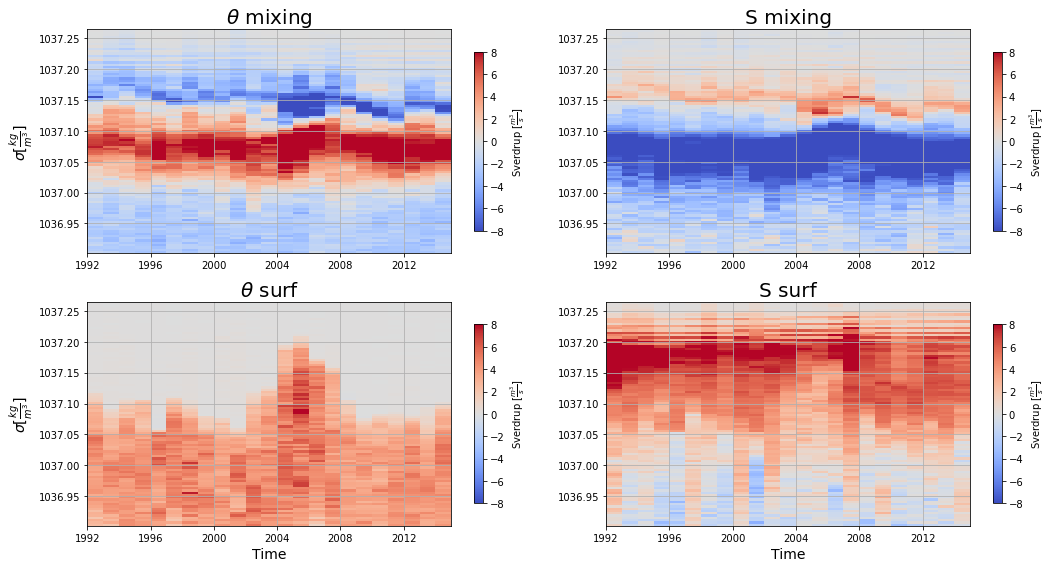

In [120]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))#, sharex=True)

omega_mix_th_resampled = (omega_mix_th/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,0].pcolormesh(pd.to_datetime(omega_mix_th_resampled.time), omega_mix_th_resampled.sigma2_bin, 
                        omega_mix_th_resampled.T, cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\theta$ mixing', fontsize=20)
#ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_mix_slt_resampled = (omega_mix_slt/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,1].pcolormesh(pd.to_datetime(omega_mix_slt_resampled.time), omega_mix_slt_resampled.sigma2_bin, 
                        omega_mix_slt_resampled.T, cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('S mixing', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_surf_th_resampled = (omega_surf_th/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(pd.to_datetime(omega_surf_th_resampled.time), omega_surf_th_resampled.sigma2_bin, 
                        omega_surf_th_resampled.T, cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'$\theta$ surf', fontsize=20)
#ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

omega_surf_slt_resampled = (omega_surf_slt/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(pd.to_datetime(omega_surf_slt_resampled.time), omega_surf_slt_resampled.sigma2_bin, 
                        omega_surf_slt_resampled.T, cmap='coolwarm', vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('S surf', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()
plt.tight_layout();

In [124]:
omega_trans_rate_prime = - omega_trans_rate.differentiate(coord='sigma2_bin')
omega_trans_rate_th_prime = -omega_trans_rate_th.differentiate(coord='sigma2_bin')
omega_trans_rate_slt_prime = -omega_trans_rate_slt.differentiate(coord='sigma2_bin')
omega_mix_th_prime = -omega_mix_th.differentiate(coord='sigma2_bin')
omega_surf_th_prime = -omega_surf_th.differentiate(coord='sigma2_bin')
omega_mix_slt_prime = -omega_mix_slt.differentiate(coord='sigma2_bin')
omega_surf_slt_prime = -omega_surf_slt.differentiate(coord='sigma2_bin')
omega_mix_prime = -omega_mix.differentiate(coord='sigma2_bin')
omega_surf_prime = -omega_surf.differentiate(coord='sigma2_bin')

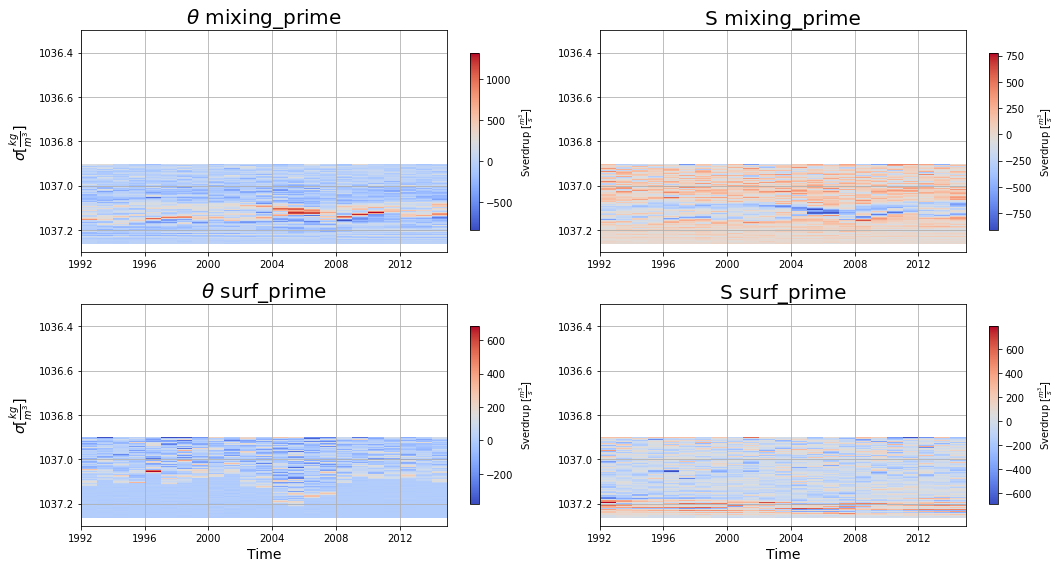

In [126]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))#, sharex=True)

omega_mix_th_resampled_prime = (omega_mix_th_prime/1e6).resample(time='AS').mean(dim='time')
c0 = ax[0,0].pcolormesh(pd.to_datetime(omega_mix_th_resampled_prime.time), omega_mix_th_resampled_prime.sigma2_bin, 
                        omega_mix_th_resampled_prime.T, cmap='coolwarm')#, vmin=-8, vmax=8)
plt.colorbar(c0, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\theta$ mixing_prime', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.3)
ax[0,0].grid()

omega_mix_slt_resampled_prime = (omega_mix_slt_prime/1e6).resample(time='AS').mean(dim='time')
c1 = ax[0,1].pcolormesh(pd.to_datetime(omega_mix_slt_resampled_prime.time), omega_mix_slt_resampled_prime.sigma2_bin, 
                        omega_mix_slt_resampled_prime.T, cmap='coolwarm')#, vmin=-8, vmax=8)
plt.colorbar(c1, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,1])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title('S mixing_prime', fontsize=20)
ax[0,1].set_ylim(1037.3, 1036.3)
ax[0,1].grid()

omega_surf_th_resampled_prime = (omega_surf_th_prime/1e6).resample(time='AS').mean(dim='time')
c2 = ax[1,0].pcolormesh(pd.to_datetime(omega_surf_th_resampled_prime.time), omega_surf_th_resampled_prime.sigma2_bin, 
                        omega_surf_th_resampled_prime.T, cmap='coolwarm')#, vmin=-8, vmax=8)
plt.colorbar(c2, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title(r'$\theta$ surf_prime', fontsize=20)
ax[1,0].set_ylim(1037.3, 1036.3)
ax[1,0].grid()

omega_surf_slt_resampled_prime = (omega_surf_slt_prime/1e6).resample(time='AS').mean(dim='time')
c3 = ax[1,1].pcolormesh(pd.to_datetime(omega_surf_slt_resampled_prime.time), omega_surf_slt_resampled_prime.sigma2_bin, 
                        omega_surf_slt_resampled_prime.T, cmap='coolwarm')#, vmin=-8, vmax=8)
plt.colorbar(c3, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title('S surf_prime', fontsize=20)
ax[1,1].set_ylim(1037.3, 1036.3)
ax[1,1].grid()
plt.tight_layout();

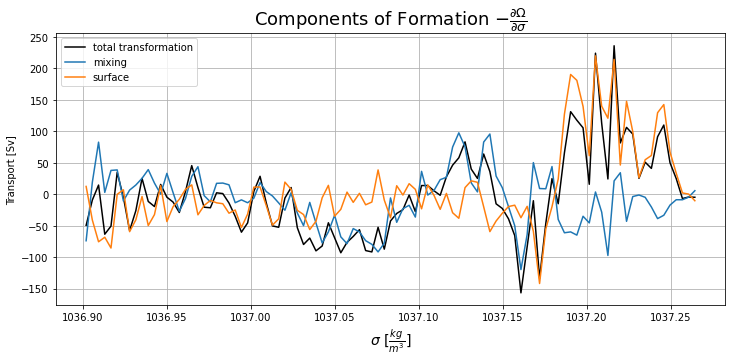

In [128]:
(omega_trans_rate_prime/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')
(omega_mix_prime/1e6).mean(dim='time').plot(label='mixing')
(omega_surf_prime/1e6).mean(dim='time').plot(label='surface')
plt.legend()
plt.grid()
#plt.xlim(1036.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Components of Formation $-\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

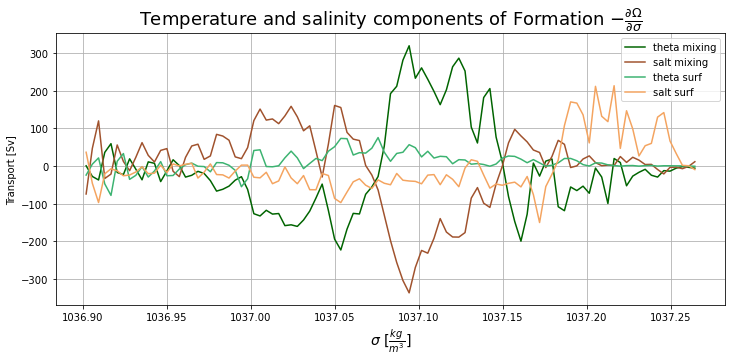

In [129]:
(omega_mix_th_prime/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(omega_mix_slt_prime/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(omega_surf_th_prime/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(omega_surf_slt_prime/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
#plt.xlim(1036.5, 1037.5)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ $[\frac{kg}{m^3}]$', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'Temperature and salinity components of Formation $-\frac{\partial \Omega}{\partial \sigma}$', fontsize=18);

In [121]:
omega_terms = xr.merge([omega_mix_th.rename('mix_th'), 
                        omega_mix_slt.rename('mix_slt'),
                        omega_surf_th.rename('surf_th'),
                        omega_surf_slt.rename('surf_slt')])

In [122]:
omega_terms = omega_terms.fillna(0.)

In [123]:
omega_terms_mon_clim = omega_terms.groupby('time.month').mean(dim='time')
omega_terms_anom = omega_terms.groupby('time.month') - omega_terms_mon_clim

In [124]:
omega_terms_anom_roll = (omega_terms_anom.rolling(time=12).mean(dim='time')).load()

In [125]:
omega_terms_anom_roll

<xarray.Dataset>
Dimensions:     (sigma2_bin: 999, time: 72)
Coordinates:
  * time        (time) datetime64[ns] 2005-01-15 2005-02-12 ... 2010-12-15
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    mix_th      (time, sigma2_bin) float64 nan nan nan nan ... 288.0 297.4 252.6
    mix_slt     (time, sigma2_bin) float64 nan nan nan ... 1.044e+04 -5.377e+03
    surf_th     (time, sigma2_bin) float64 nan nan nan ... 16.1 -18.94 -253.4
    surf_slt    (time, sigma2_bin) float64 nan nan nan ... -7.917e+03 -1.558e+04

In [126]:
aabw_omega_terms = omega_terms_anom_roll.sel(**aabw_bin)

NameError: name 'aabw_bin' is not defined

Text(0, 0.5, 'Transport [Sv]')

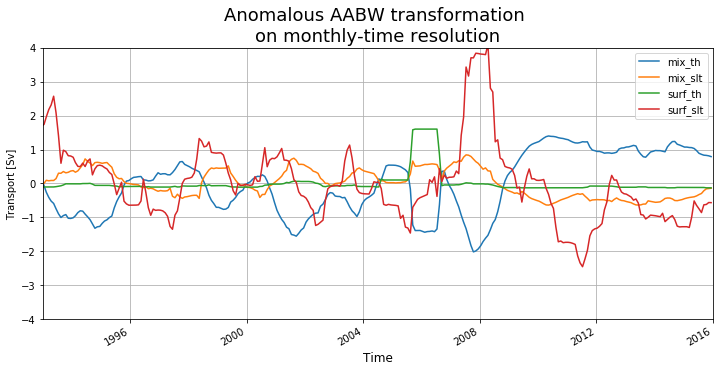

In [128]:
plt.figure(figsize=(12,5))
for dvar in aabw_omega_terms.data_vars:
    (aabw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-4,4)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous AABW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

In [129]:
cdw_omega_terms = aabw_omega_terms - omega_terms_anom_roll.sel(**cdw_bin)

Text(0, 0.5, 'Transport [Sv]')

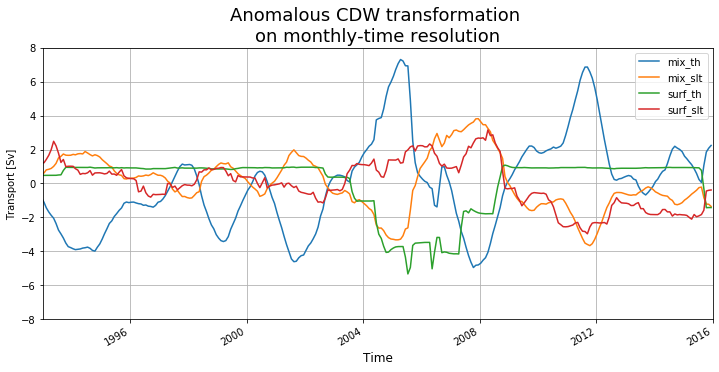

In [130]:
plt.figure(figsize=(12,5))
for dvar in cdw_omega_terms.data_vars:
    (cdw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-8,8)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous CDW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

### SAM INDEX

In [ ]:
import pandas as pd

In [ ]:
ds_sam = pd.read_csv('/home/jovyan/WMT/Climate-Indices/newsam.1957.2007.seas.txt', delim_whitespace=True, parse_dates=True)

In [ ]:
ds_sam

In [ ]:
ds_sam.ANN.plot()

In [ ]:
sam = xr.Dataset(ds_sam, coords={'time':ds_sam.index.rename('time')})

In [ ]:
sam

In [ ]:
sam = sam.drop('time')

In [ ]:
sam

In [ ]:
sam = sam.swap_dims(dims_dict={'dim_0':'time'})

In [ ]:
sam['time'] = sam.dim_0.rename('time')

In [ ]:
sam

In [ ]:
from scipy.signal import detrend

In [ ]:
sam_ann_detrended = xr.apply_ufunc(detrend, sam.ANN.fillna(0),
                                    kwargs={'axis': 0}).where(~sam.ANN.isnull())

In [ ]:
sam_ann_detrended.plot(figsize=(10,5))
plt.grid()

In [ ]:
sam_ecco_time = sam_ann_detrended.sel(time=slice('1992', '2015'))

In [ ]:
print(sam_ecco_time)

In [ ]:
sam_ecco_time.plot(color='grey', label='SAM')
plt.grid()

In [ ]:
plt.figure(figsize=(12,5))
sam_ecco_time.plot(color='k', label='SAM', linewidth=2)
for dvar in aabw_omega_terms.data_vars:
    (aabw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-4,4)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous AABW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

In [ ]:
plt.figure(figsize=(12,5))
sam_ecco_time.plot(color='k', label='SAM', linewidth=2)
for dvar in cdw_omega_terms.data_vars:
    (cdw_omega_terms[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-8,8)
plt.xlim('1993', '2016')
plt.grid()
plt.title('Anomalous CDW transformation \non monthly-time resolution', fontsize=18)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Transport [Sv]')

## Timeseries of AABW, CDW, HSSW

In [109]:
aabw_bin = dict(sigma2_bin=1037.199, method='nearest')
cdw_bin = dict(sigma2_bin=1037.118, method='nearest')
hsw_bin = dict(sigma2_bin=1037.357, method='nearest')

In [110]:
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), omega_trans_rate.rename('omega_trans_rate'), 
                             psi_vel.rename('psi_vel'), R2.rename('R2'), R1.rename('R1')])

In [111]:
wmt_budget_terms = wmt_budget_terms.fillna(0.)

In [112]:
aabw_wmt_budget_terms = wmt_budget_terms.sel(**aabw_bin)

In [113]:
aabw_wmt_budget_terms

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
    sigma2_bin        float64 1.037e+03
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    omega_trans_rate  (time) float64 0.0 -5.139e+05 -5.846e+05 ... 1.47e+06 0.0
    psi_vel           (time) float64 0.0 -4.57e+06 -1.656e+06 ... -1.557e+06 0.0
    R2                (time) float64 -6.141e+05 6.211e+05 ... 2.073e+05
    R1                (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>

In [114]:
aabw_mon_clim = aabw_wmt_budget_terms.groupby('time.month').mean(dim='time')
aabw_anom = aabw_wmt_budget_terms.groupby('time.month') - aabw_mon_clim

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [115]:
aabw_anom

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
    sigma2_bin        float64 1.037e+03
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
    month             (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    omega_trans_rate  (time) float64 8.099e+05 -5.472e+04 ... 9.054e+05
    psi_vel           (time) float64 3.804e+06 -1.974e+06 ... 2.701e+06
    R2                (time) float64 -7.229e+05 4.517e+05 ... 1.422e+05
    R1                (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [116]:
aabw_anom_roll = aabw_anom.chunk({'time':6}).rolling(time=12).mean(dim='time')

Text(0.5, 1.0, 'Anomalous AABW on monthly-time resolution')

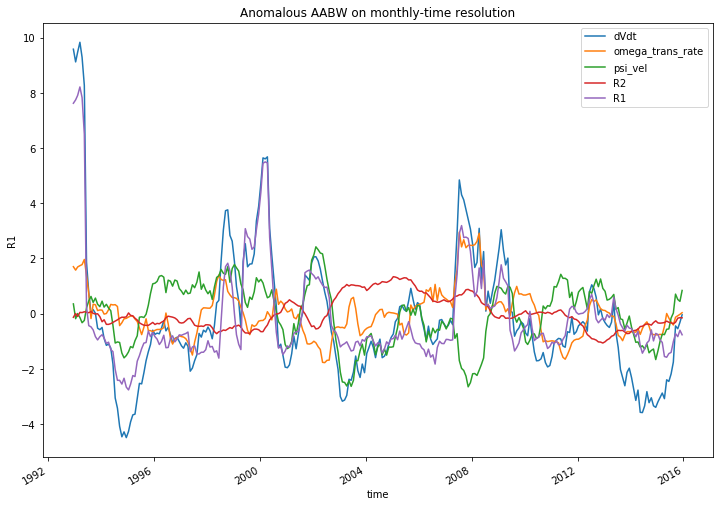

In [117]:
plt.figure(figsize=(12,8))
for dvar in aabw_anom.data_vars:
    (aabw_anom_roll[dvar]/1e6).plot(label=str(dvar))
plt.legend()
#plt.ylim(-15,20)
plt.title('Anomalous AABW on monthly-time resolution')

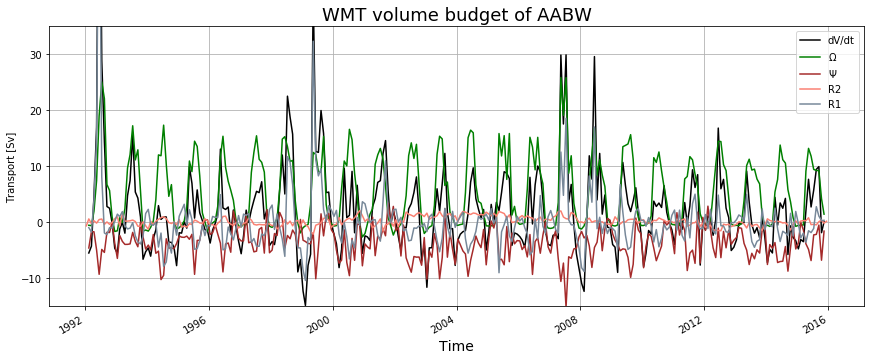

In [118]:
(dVdt/1e6).sel(**aabw_bin).plot(label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).plot(label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).plot(label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).plot(label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).plot(label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-15, 35)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

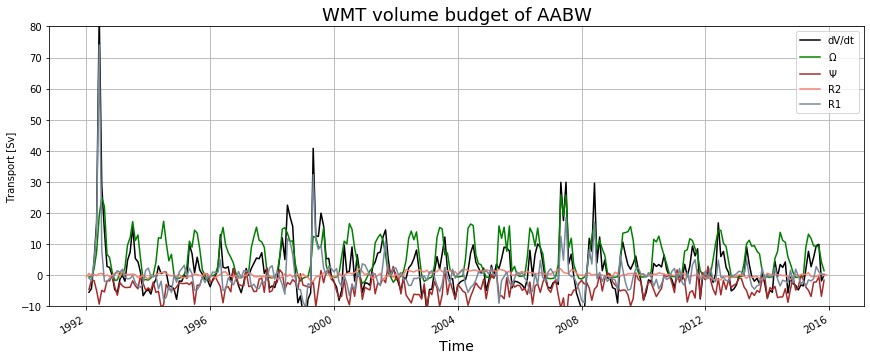

In [119]:
(dVdt/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='dV/dt', color='k', figsize=(12,5))
(omega_trans_rate/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label=r'$\Omega$', color='green')
(psi_vel/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label=r'$\Psi$', color='brown')
(R2/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='R2', color='salmon')
(R1/1e6).sel(**aabw_bin).resample(time='MS').mean(dim='time').plot(x='time', label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-10, 80)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of AABW', fontsize=18);

In [120]:
cdw_wmt_budget_terms = aabw_wmt_budget_terms - wmt_budget_terms.sel(**cdw_bin)

In [121]:
cdw_wmt_budget_terms

<xarray.Dataset>
Dimensions:           (time: 288)
Coordinates:
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    time_snp          (time) datetime64[ns] NaT 1992-03-01 ... 2015-12-01 NaT
Data variables:
    dVdt              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    omega_trans_rate  (time) float64 0.0 -9.408e+05 -2.869e+06 ... 2.325e+06 0.0
    psi_vel           (time) float64 0.0 4.177e+06 5.014e+06 ... 3.488e+06 0.0
    R2                (time) float64 1.991e+04 1.196e+06 ... -5.836e+05
    R1                (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>

In [122]:
cdw_mon_clim = cdw_wmt_budget_terms.groupby('time.month').mean(dim='time')
cdw_anom = cdw_wmt_budget_terms.groupby('time.month') - cdw_mon_clim

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 24 times more chunks
  return self.array[key]


In [123]:
cdw_anom_roll = cdw_anom.chunk({'time':6}).rolling(time=12).mean(dim='time')

Text(0.5, 1.0, 'Anomalous CDW on monthly-time resolution')

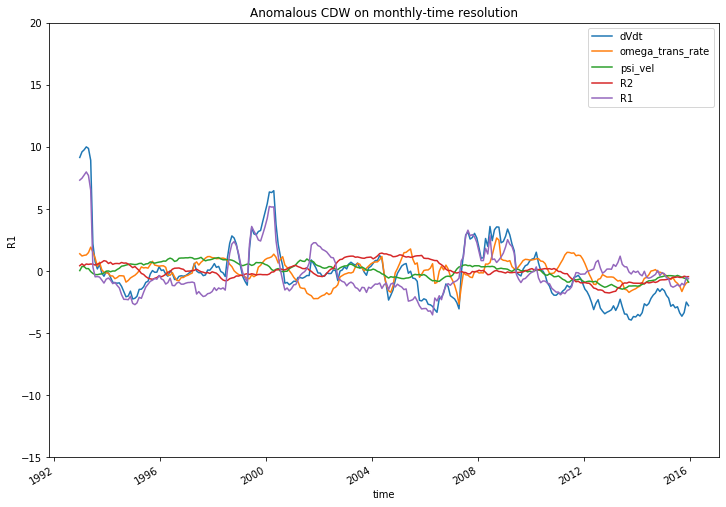

In [124]:
plt.figure(figsize=(12,8))
for dvar in cdw_anom.data_vars:
    (cdw_anom_roll[dvar]/1e6).plot(label=str(dvar))
plt.legend()
plt.ylim(-15,20)
plt.title('Anomalous CDW on monthly-time resolution')

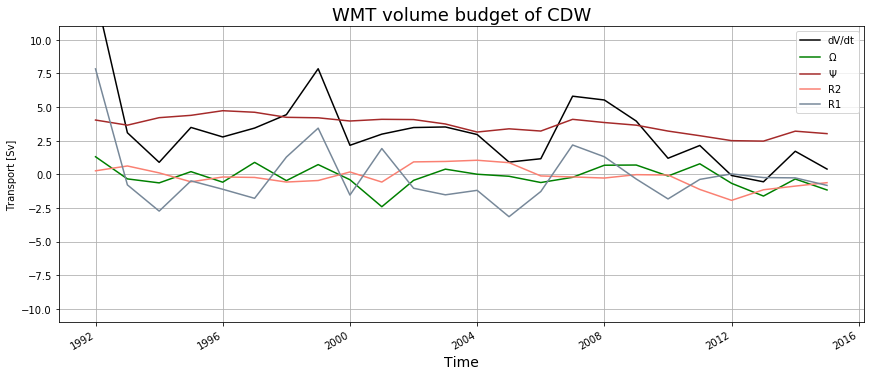

In [125]:
((dVdt.sel(**aabw_bin) - dVdt.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                             label='dV/dt', color='k', figsize=(12,5))
((omega_trans_rate.sel(**aabw_bin) - omega_trans_rate.sel(**cdw_bin))/1e6).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                                     label=r'$\Omega$', color='green')
((psi_vel/1e6).sel(**aabw_bin) - (psi_vel/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                                         label=r'$\Psi$', color='brown')
((R2/1e6).sel(**aabw_bin) - (R2/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R2', color='salmon')
((R1/1e6).sel(**aabw_bin) - (R1/1e6).sel(**cdw_bin)).resample(time='AS').mean(dim='time').plot(x='time', 
                                                                                               label='R1', color='lightslategray')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
plt.ylim(-11, 11)
plt.tight_layout()
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r'WMT volume budget of CDW', fontsize=18);

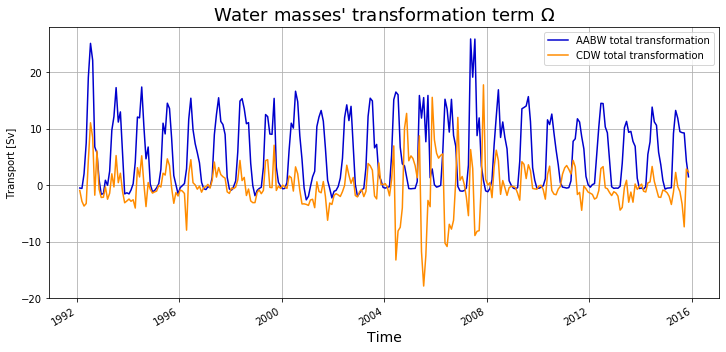

In [126]:
(omega_trans_rate/1e6).sel(**aabw_bin).plot(figsize=(12,5), label='AABW total transformation', color='mediumblue')
((omega_trans_rate/1e6).sel(**aabw_bin) - (omega_trans_rate/1e6)).sel(**cdw_bin).plot(label='CDW total transformation', color='darkorange')
#(omega_trans_rate/1e6).sel(**hsw_bin).plot(label='HSSW total transformation', color='k')
plt.legend()
plt.grid()
#plt.xlim(1035.5, 1037.5)
#plt.ylim(-6, 6)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'Transport [Sv]')
plt.title(r"Water masses' transformation term $\Omega$", fontsize=18);